# 1. Importing the data

## 1.1 Dataset preparation
Before the acutal clustering can take place, the data need to be imported and prepared. 
#### 1. The following columns will be dropped:
- junction_id: because it is a unique id, it wont be of any value for clustering
- junction_type: this is always the same value "traffic_light" 
- x,y: I was skeptical about including the location values. I included them at first but in the later analyses I found them to be of no value
- z: in the example scenarios, there are no z-values 


#### 2. The roundabout field will be converted from {true|false} to {0|1} 
#### 3. edge_types will be replaced
'edge_types' currently is a list of all types of edges connected to a junction. This needs to be converted into a set of 
numerical values. For this task a MultiLabelBinarizer(MLB) is used.
#### 4. trafficlight_count is a column containing the amount of traffic lights, their ids and a list of connection data for later use. For clustering it will be replaced by the amount of traffic lights
## 1.2 Approach
The datasets for the TAPAS Cologne scenario and for the LUst Luxembourg scenario will be analysed. They are the largest available datasets for SUMO. To better compare my results I found it interesting to analyze two different scenarios. It should be interesting to see whether the clustering results will be similar for different cities. In addition I created a combined dataset. The underlying idea is that maybe adding more data will result in better clustering results. 

In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
#import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
import copy

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer

"""
trafficlight_count column is a list in the form:
[
    amount_of_trafficlight,
    traffic_light_id,
    [connections]
]
while connections are of the form: [from, to, tl, dir, state]

"""
columns=["junction_id","junction_type","x","y","z","isRoundabout","trafficlight_count","avg_lane_speed","lane_speeds_std_deviation",
     "avg_lane_length","lane_length_standard_deviation","edge_types","edge_prioities","number_of_lanes"
     ,"intl_avg_lane_speed","intl_lane_speeds_std_deviation",
     "intl_avg_lane_length","intl_lane_length_standard_deviation","intl_edge_types","intl_edge_prioities","intl_number_of_lanes"]


def prepare_columns(df):      
    df= df.drop(df.columns[[0, 1,2,3, 4]], axis=1)
    
    fixed_types= df['edge_types'].map(lambda x: ast.literal_eval(x))
    df['isRoundabout']= df['isRoundabout'].astype(float)    
    result= mlb.transform(fixed_types)
    
    
    dfn_columns= list(mlb.classes_)
    dfn_columns[0]="No Type"
    dfn= pd.DataFrame(result,columns=dfn_columns)
    
    df=df.drop('edge_types',1)
    df=df.drop('intl_edge_types',1)
    #to turn off the MLP and ignore the type features just return df instead of concatting df and dfn together
    #and then run all cells
    #return df
    
    return pd.concat([df,dfn],axis=1)


     
def prepTrafficLightInfo(df):    
    df.columns= copy.copy(columns)
    tlcol= df["trafficlight_count"].map(lambda x: ast.literal_eval(x))
    df["trafficlight_count"]= map(lambda x: x[0], tlcol)
    
        
lust_file_name= "dataset-lust-tl.csv"
lust_raw_df= pd.read_csv(lust_file_name)
prepTrafficLightInfo(lust_raw_df)
print "lust dataset loaded, {} rows, cols".format(lust_raw_df.shape)

cgn_file_name= "dataset-cgn-tl.csv"
cgn_raw_df= pd.read_csv(cgn_file_name)
prepTrafficLightInfo(cgn_raw_df)
print "cgn dataset loaded, {} rows".format(cgn_raw_df.shape)

combined_raw_df=pd.concat([lust_raw_df,cgn_raw_df])
print "combined dataset loaded, {} rows".format(combined_raw_df.shape)

mlb = MultiLabelBinarizer()
fixed_types= combined_raw_df['edge_types'].map(lambda x: ast.literal_eval(x))
mlb=mlb.fit(fixed_types)
print "\nMLB found the following classes:{}\n".format(list(mlb.classes_))

lust_dataset= prepare_columns(lust_raw_df)

print "lust dataset prepared, {} rows, cols".format(lust_dataset.shape)

cgn_dataset= prepare_columns(cgn_raw_df)
print "lust dataset prepared, {} rows, cols".format(cgn_dataset.shape)

combined_dataset= pd.concat([cgn_dataset,lust_dataset],axis=0)
print "lust dataset prepared, {} rows, cols".format(combined_dataset.shape)

lust dataset loaded, (202, 21) rows, cols
cgn dataset loaded, (1218, 21) rows
combined dataset loaded, (1420, 21) rows

MLB found the following classes:[None, 'highway.living_street', 'highway.motorway', 'highway.motorway_link', 'highway.primary', 'highway.primary.bridge', 'highway.primary.tunnel', 'highway.primary_link', 'highway.primary|railway.tram', 'highway.residential', 'highway.secondary', 'highway.secondary_link', 'highway.tertiary', 'highway.tertiary_link', 'highway.tertiary|railway.tram', 'highway.trunk', 'highway.trunk_link', 'highway.unclassified']

lust dataset prepared, (202, 32) rows, cols
lust dataset prepared, (1218, 32) rows, cols
lust dataset prepared, (1420, 32) rows, cols


# 2. Dataset Analysis
The following table shows that features are on different scales. For example speed in km/h, length in meters and isRoundabout as a boolean feature. Feature Scaling must be applied as a next step to prepare for clustering the data. 
Two different scaling algorithms will be used and evaluated throughout the rest of the notebook.

In [2]:
#exclude the values of the MLB here, 
#they make the table unnecessarily large while adding no value because their statistics are trivial
display(combined_dataset.ix[:,"isRoundabout":"intl_number_of_lanes"].describe())

isRoundabout  trafficlight_count  avg_lane_speed  \
count   1420.000000         1420.000000     1420.000000   
mean       0.041549            9.895775       13.815991   
std        0.199627            5.280342        2.006128   
min        0.000000            1.000000        2.780000   
25%        0.000000            5.000000       13.890000   
50%        0.000000           10.000000       13.890000   
75%        0.000000           14.000000       13.890000   
max        1.000000           46.000000       48.610000   

       lane_speeds_std_deviation  avg_lane_length  \
count                1420.000000      1420.000000   
mean                    0.748726       139.582831   
std                     1.470907       142.816742   
min                     0.000000         6.450000   
25%                     0.000000        54.331071   
50%                     0.000000       102.668333   
75%                     1.382295       169.387875   
max                    34.720000      1386.280000   

       lane_length_standard_deviation  edge_prioities  number_of_lanes  \
count                     1420.000000     1420.000000      1420.000000   
mean                        68.643406        6.867463         4.723239   
std                        101.624359        1.515603         2.180093   
min                          0.000000        3.000000         1.000000   
25%                         12.241999        6.000000         3.000000   
50%                         38.379295        6.750000         4.000000   
75%                         81.535628        8.000000         6.000000   
max                       1537.645770       12.000000        16.000000   

       intl_avg_lane_speed  intl_lane_speeds_std_deviation  \
count          1420.000000                     1420.000000   
mean              2.070447                        0.049981   
std               5.099828                        0.212553   
min               0.000000                        0.000000   
25%               0.000000                        0.000000   
50%               0.000000                        0.000000   
75%               0.000000                        0.000000   
max              18.808182                        2.253391   

       intl_avg_lane_length  intl_lane_length_standard_deviation  \
count           1420.000000                          1420.000000   
mean               1.875695                             0.678021   
std                4.999283                             1.834956   
min                0.000000                             0.000000   
25%                0.000000                             0.000000   
50%                0.000000                             0.000000   
75%                0.000000                             0.000000   
max               34.281875                            12.177972   

       intl_edge_prioities  intl_number_of_lanes  
count          1420.000000           1420.000000  
mean             -0.142254              1.647887  
std               0.349433              4.326683  
min              -1.000000              0.000000  
25%               0.000000              0.000000  
50%               0.000000              0.000000  
75%               0.000000              0.000000  
max               0.000000             46.000000

The next code block gives an overview of which different junctions types exist regarding the amount of traffic lights they control. 
For example, some junctions only have 4 traffic lights on 4 lanes, while others may have many more depending on how many lanes they contain. 

In [3]:
unique_trafficlightcount_cgn= cgn_dataset["trafficlight_count"].unique()
unique_trafficlightcount_lust= lust_dataset["trafficlight_count"].unique()
unique_trafficlightcount_combined= combined_dataset["trafficlight_count"].unique()
unique_trafficlightcount_cgn.sort()
unique_trafficlightcount_lust.sort()
unique_trafficlightcount_combined.sort()
display ("cologne traffic light counts:",unique_trafficlightcount_cgn)
display ("lust:",unique_trafficlightcount_lust)
display ("combined:",unique_trafficlightcount_combined)


'cologne traffic light counts:'

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 27])

'lust:'

array([ 4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 46])

'combined:'

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 27, 46])

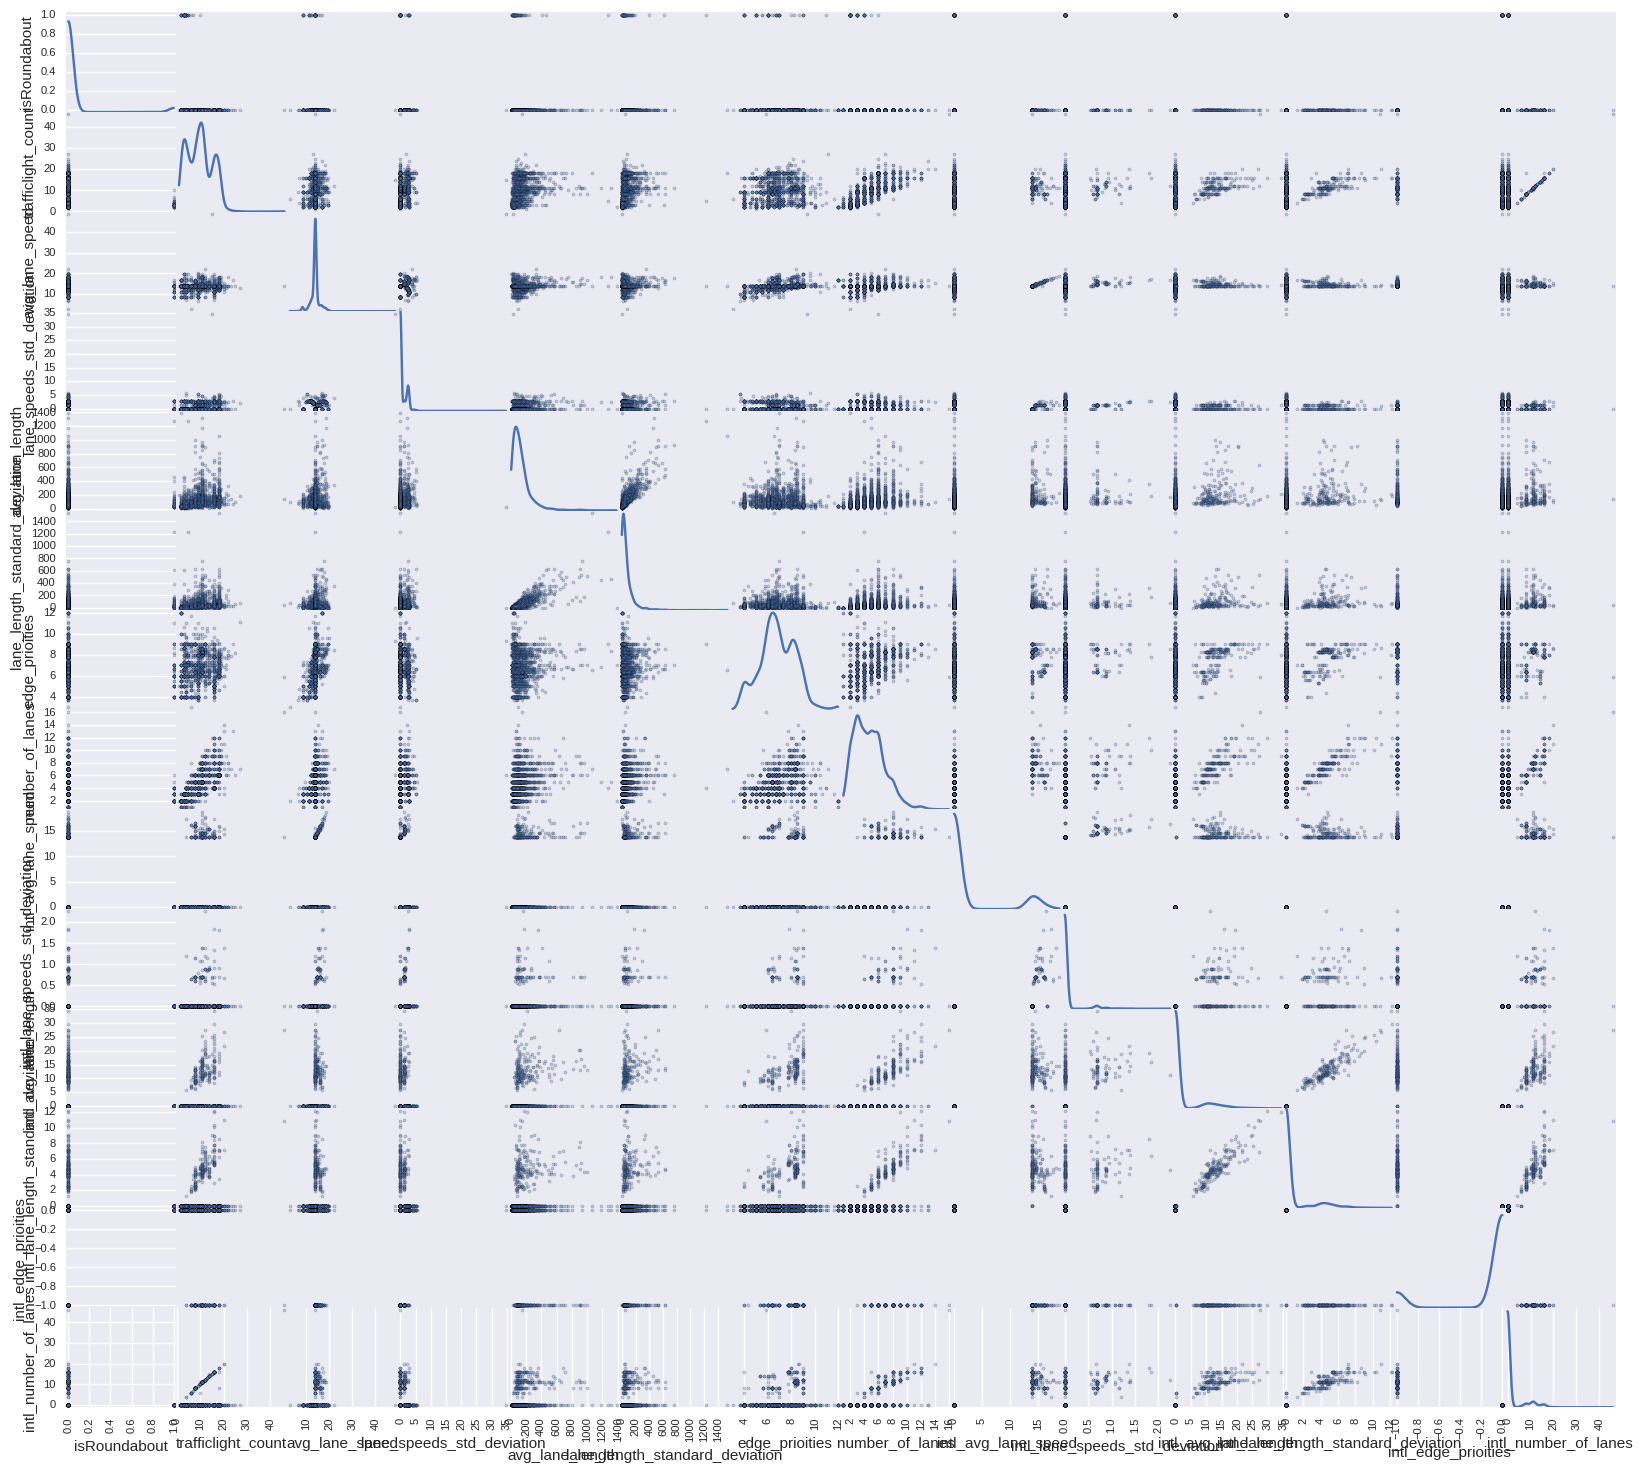

In [4]:
pd.scatter_matrix(combined_dataset.ix[:,"isRoundabout":"intl_number_of_lanes"], alpha = 0.3, figsize = (20,18), diagonal = 'kde');

# 3. Feature Scaling
As I've learned in the course and in some further reading [1] feature scaling is necessary for this dataset.



[1] http://stats.stackexchange.com/questions/19216/variables-are-often-adjusted-e-g-standardised-before-making-a-model-when-is

The results of both, the RobustScaler and the MaxAbsScaler look quite promising.



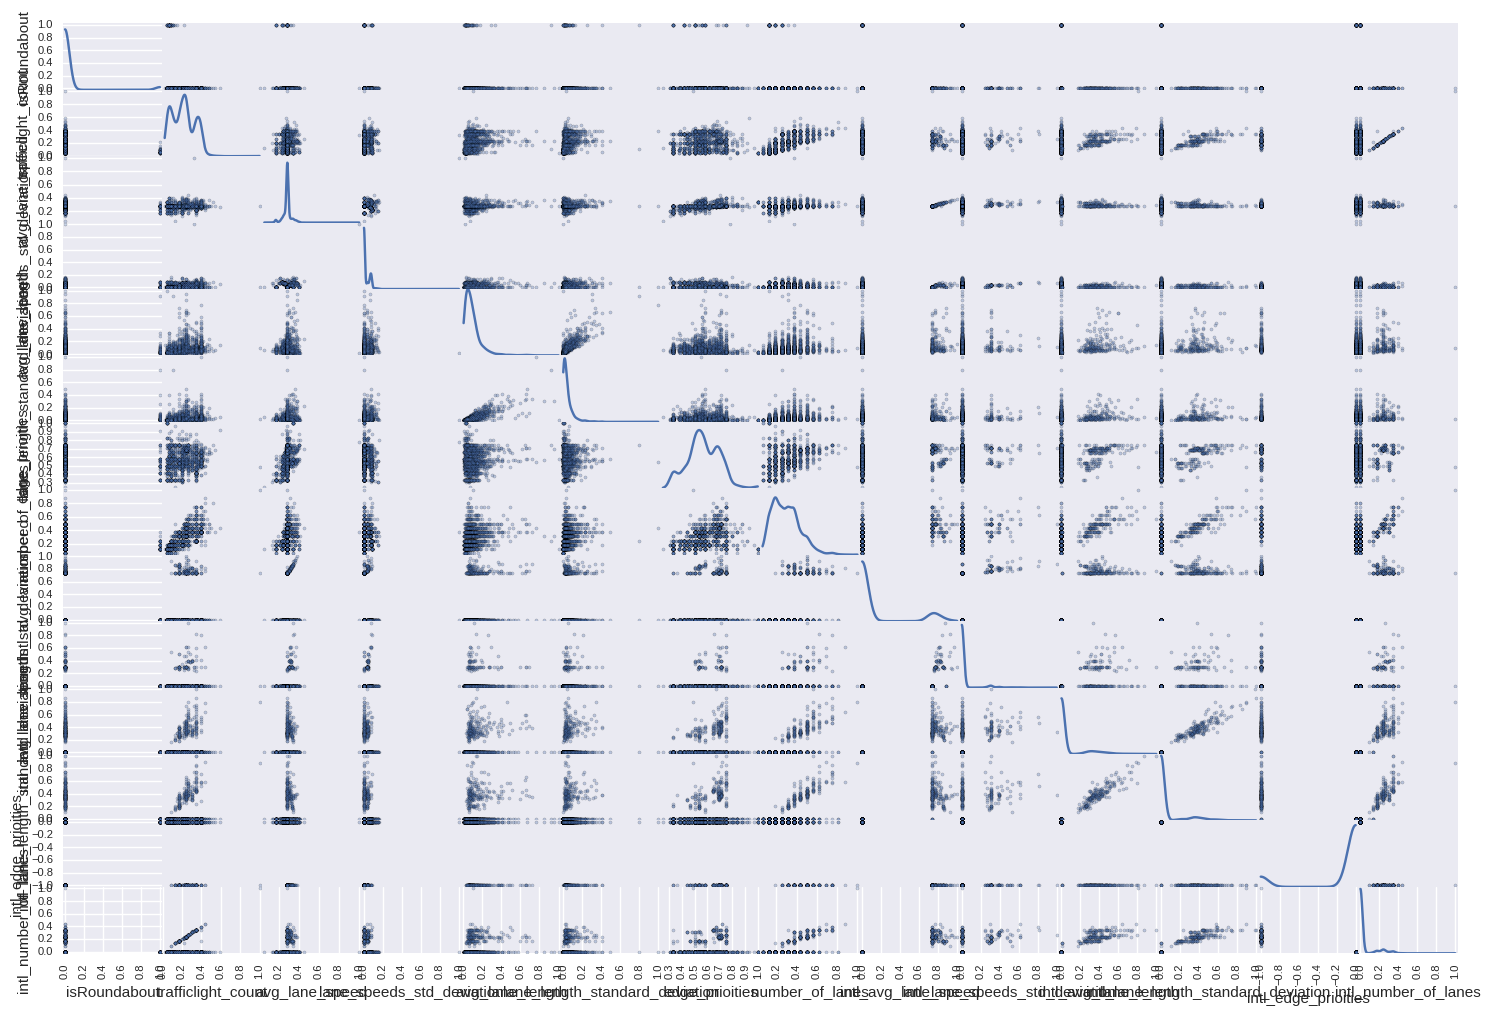

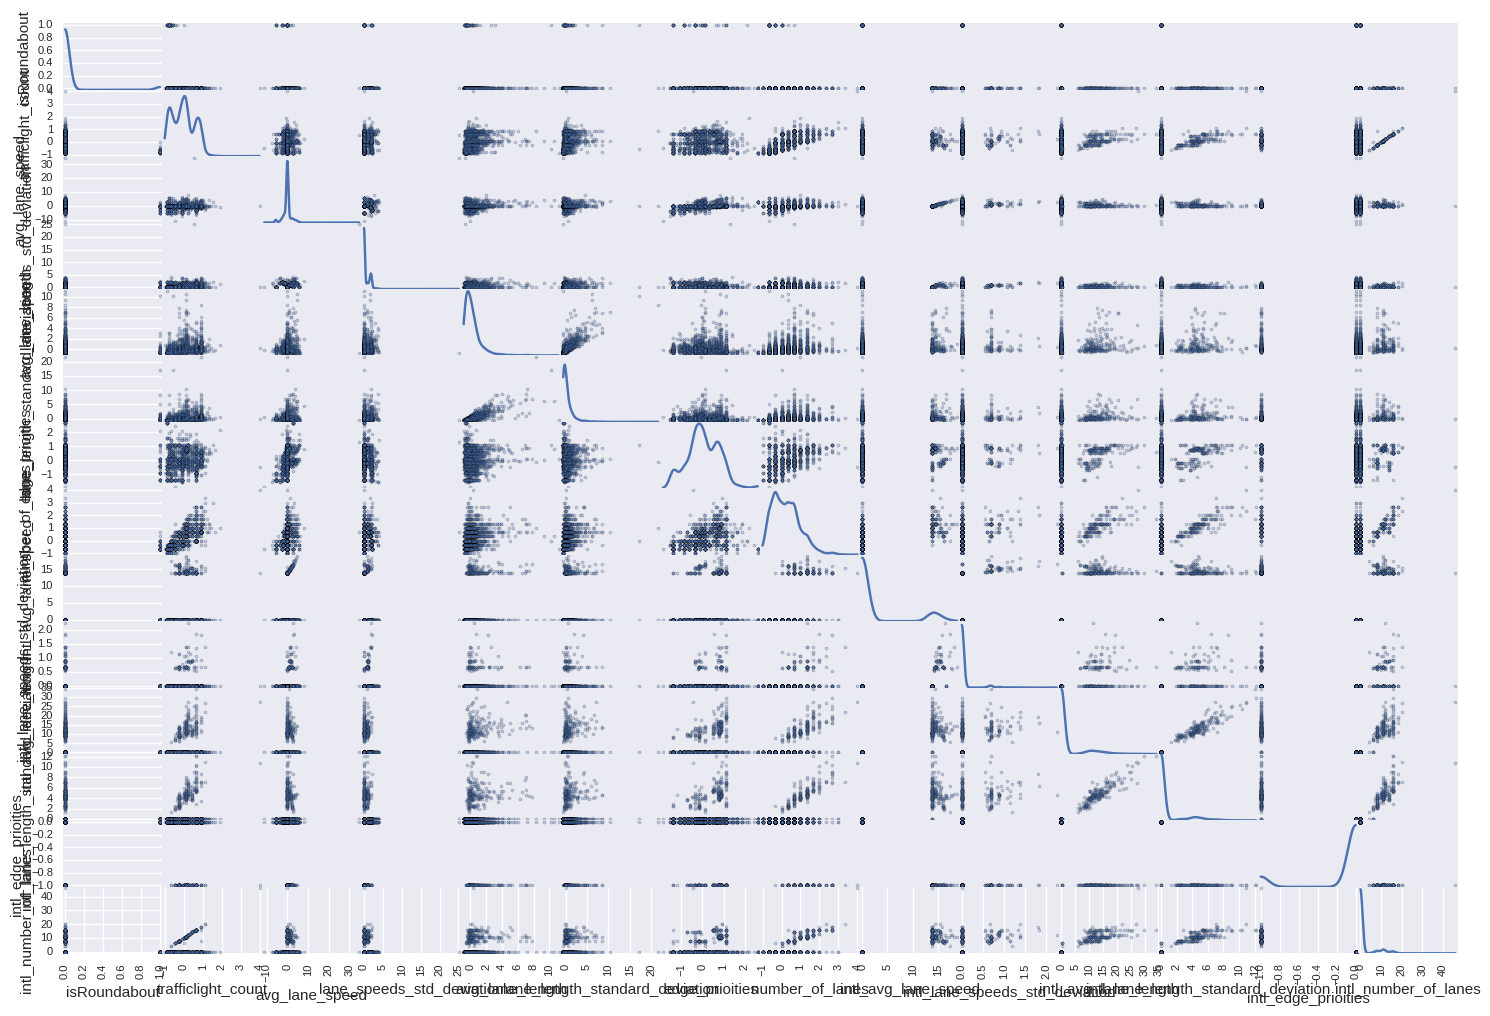

In [5]:
from sklearn import preprocessing
def scale_dataset_robust(data):
    min_max_scaler = preprocessing.RobustScaler()
    minmax = min_max_scaler.fit_transform(data)
    result= pd.DataFrame(minmax)
    result.columns=data.columns.copy()
    return result 

def scale_dataset(data):   
    scaler= preprocessing.MaxAbsScaler()
    result = scaler.fit_transform(data)
    result= pd.DataFrame(result)
    result.columns=data.columns.copy()
    return result 

scaled_lust_dataset=scale_dataset(lust_dataset)
scaled_cgn_dataset=scale_dataset(cgn_dataset)
scaled_combined_dataset=scale_dataset(combined_dataset)

scaled_lust_dataset_robust=scale_dataset_robust(lust_dataset)
scaled_cgn_dataset_robust=scale_dataset_robust(cgn_dataset)
scaled_combined_dataset_robust=scale_dataset_robust(combined_dataset)


# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(scaled_combined_dataset.ix[:,"isRoundabout":"intl_number_of_lanes"], alpha = 0.3, figsize = (18,12), diagonal = 'kde');
pd.scatter_matrix(scaled_combined_dataset_robust.ix[:,"isRoundabout":"intl_number_of_lanes"], alpha = 0.3, figsize = (18,12), diagonal = 'kde');

# 4. Dimensionality Reduction
Two different algorithms for dimensionality reduction will be applied. PCA and KernelPCA.
Because the explained variances for the 4th dimension appear to be of some importance, both 3d and 4d datasets will be computed and evaluated further.

http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/

## 4.1 KPCA
For KPCA the standard configuration and an rbf-kernel have been proven to give the best results. 
The fourth dimension (see the Chapter about cluster analysis) does not play as much of a role as I first assumed and is therefore not computed for KPCA. Furthermore I later found that the results of KPCA are not significantly different from PCA and therefore used only the PCA results subsequently.


In [6]:
from sklearn.decomposition import KernelPCA

def apply_kpca(dataset):
    kpca= KernelPCA(n_components=3,kernel='rbf', random_state=87658)
    results= kpca.fit(dataset)
    results= kpca.transform(dataset)
    return pd.DataFrame(results, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

kpca_reduced_scaled_cgn_dataset = apply_kpca(scaled_cgn_dataset)
kpca_reduced_scaled_lust_dataset = apply_kpca(scaled_lust_dataset)
kpca_reduced_scaled_combined_dataset = apply_kpca(scaled_combined_dataset)

## 4.2 Analysis of PCA components
### 4.2.1. Analysis of PCA Components for the MaxABSScaler
The total variances for all datasets seem to benefit from including a fourth dimension. Because I am unsure I will analyze 3 dimensions and 4 dimensions in the subsequent chapters.


Analyzing LUST Dataset:
Dimension 1    0.2897
Dimension 2    0.5455
Dimension 3    0.7545
Dimension 4    0.8264
Name: Explained Variance, dtype: float64


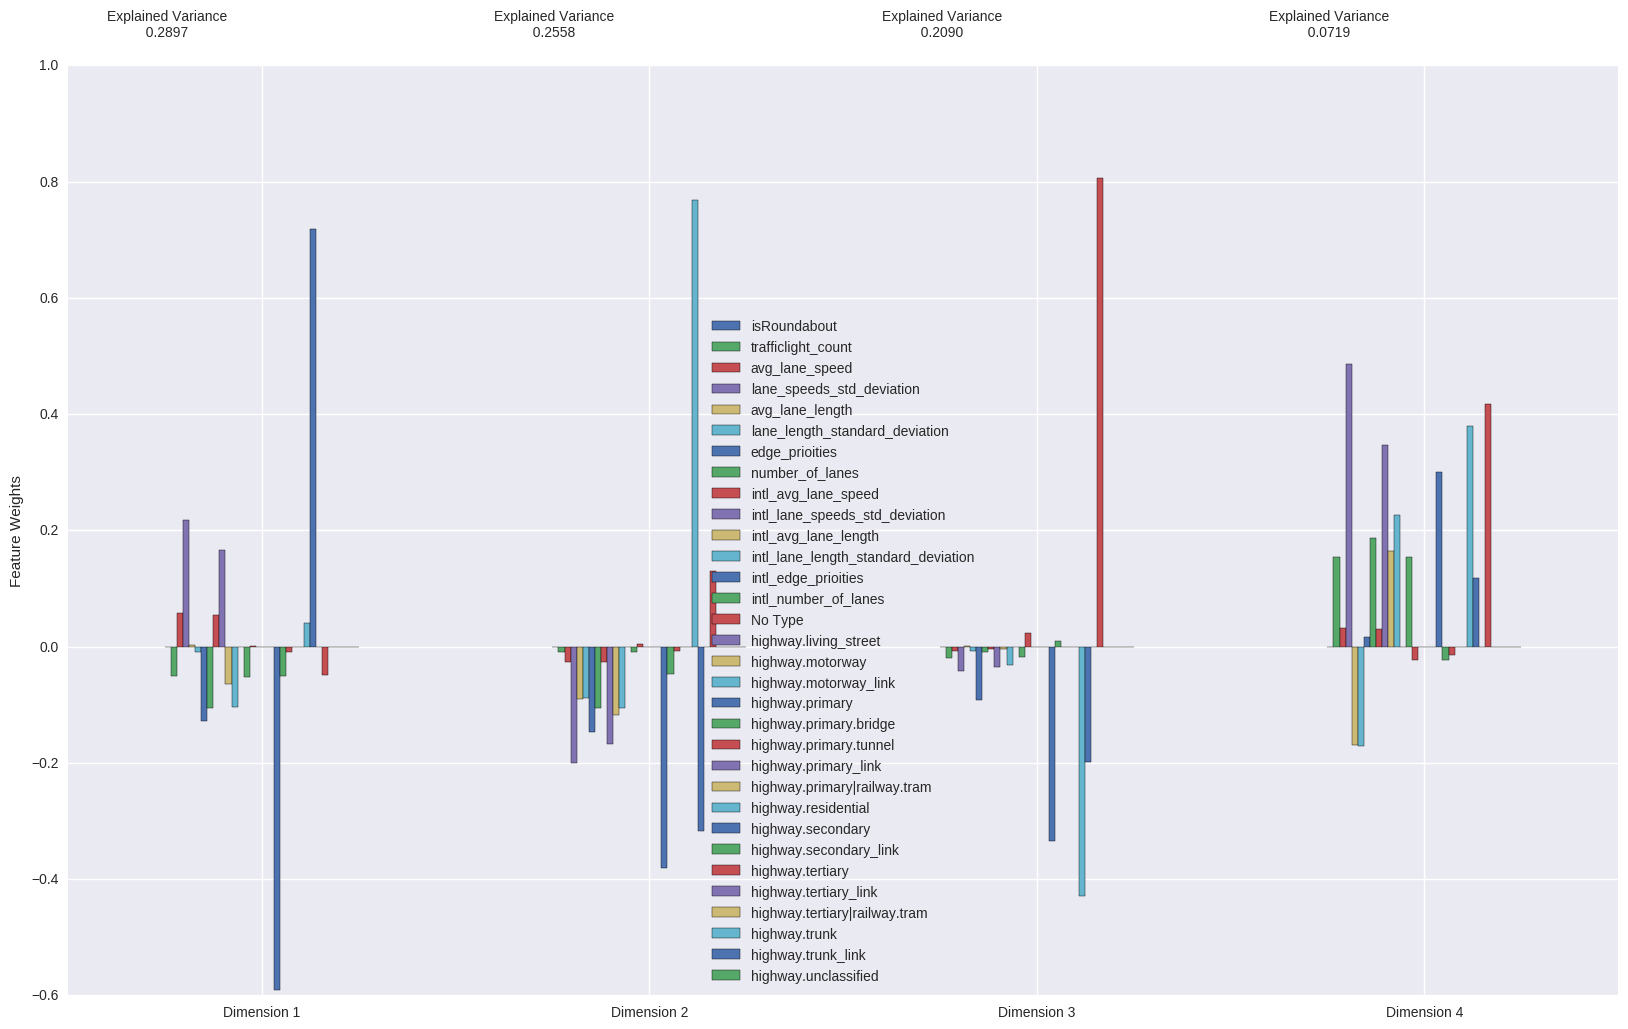

In [7]:
from sklearn.decomposition import PCA
import renders as rs

def pca_analyse(dataset):  
    pca = PCA(n_components=4).fit(dataset)
    pca_results = rs.pca_results(dataset, pca)
    print pca_results['Explained Variance'].cumsum()
print ("Analyzing LUST Dataset:")

pca_analyse (scaled_lust_dataset)

Dimension 1    0.2426
Dimension 2    0.4504
Dimension 3    0.6273
Dimension 4    0.7379
Name: Explained Variance, dtype: float64


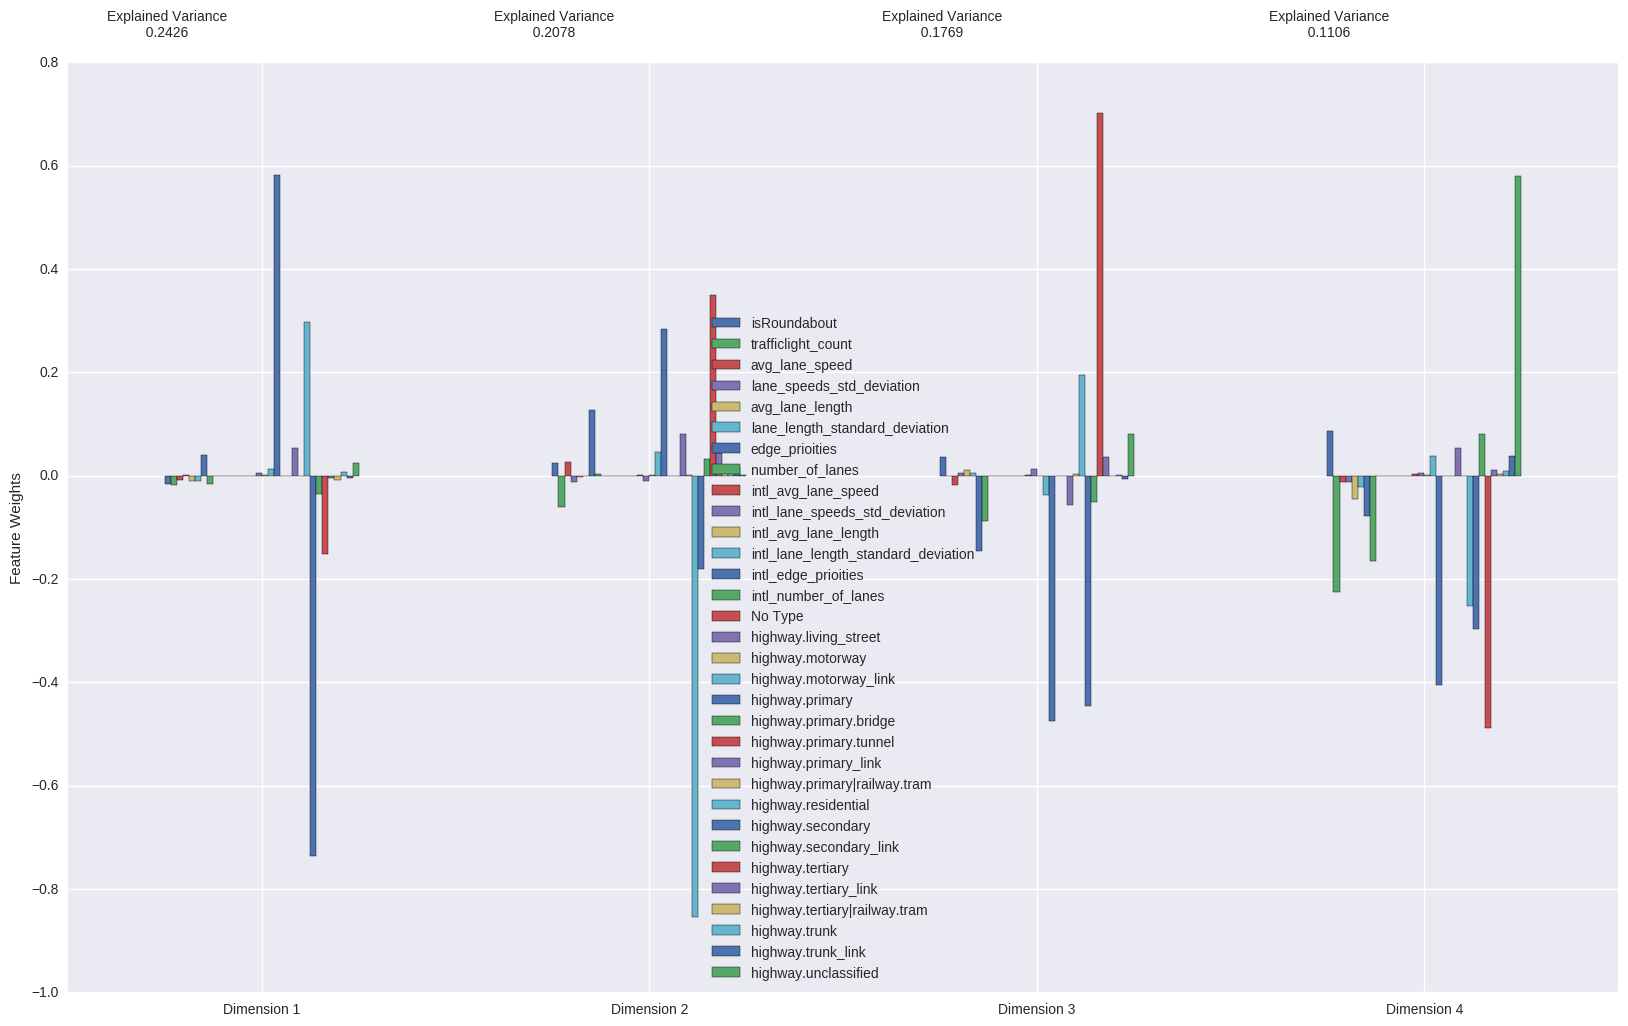

In [8]:
pca_analyse (scaled_cgn_dataset)

Dimension 1    0.2347
Dimension 2    0.4203
Dimension 3    0.5884
Dimension 4    0.7259
Name: Explained Variance, dtype: float64


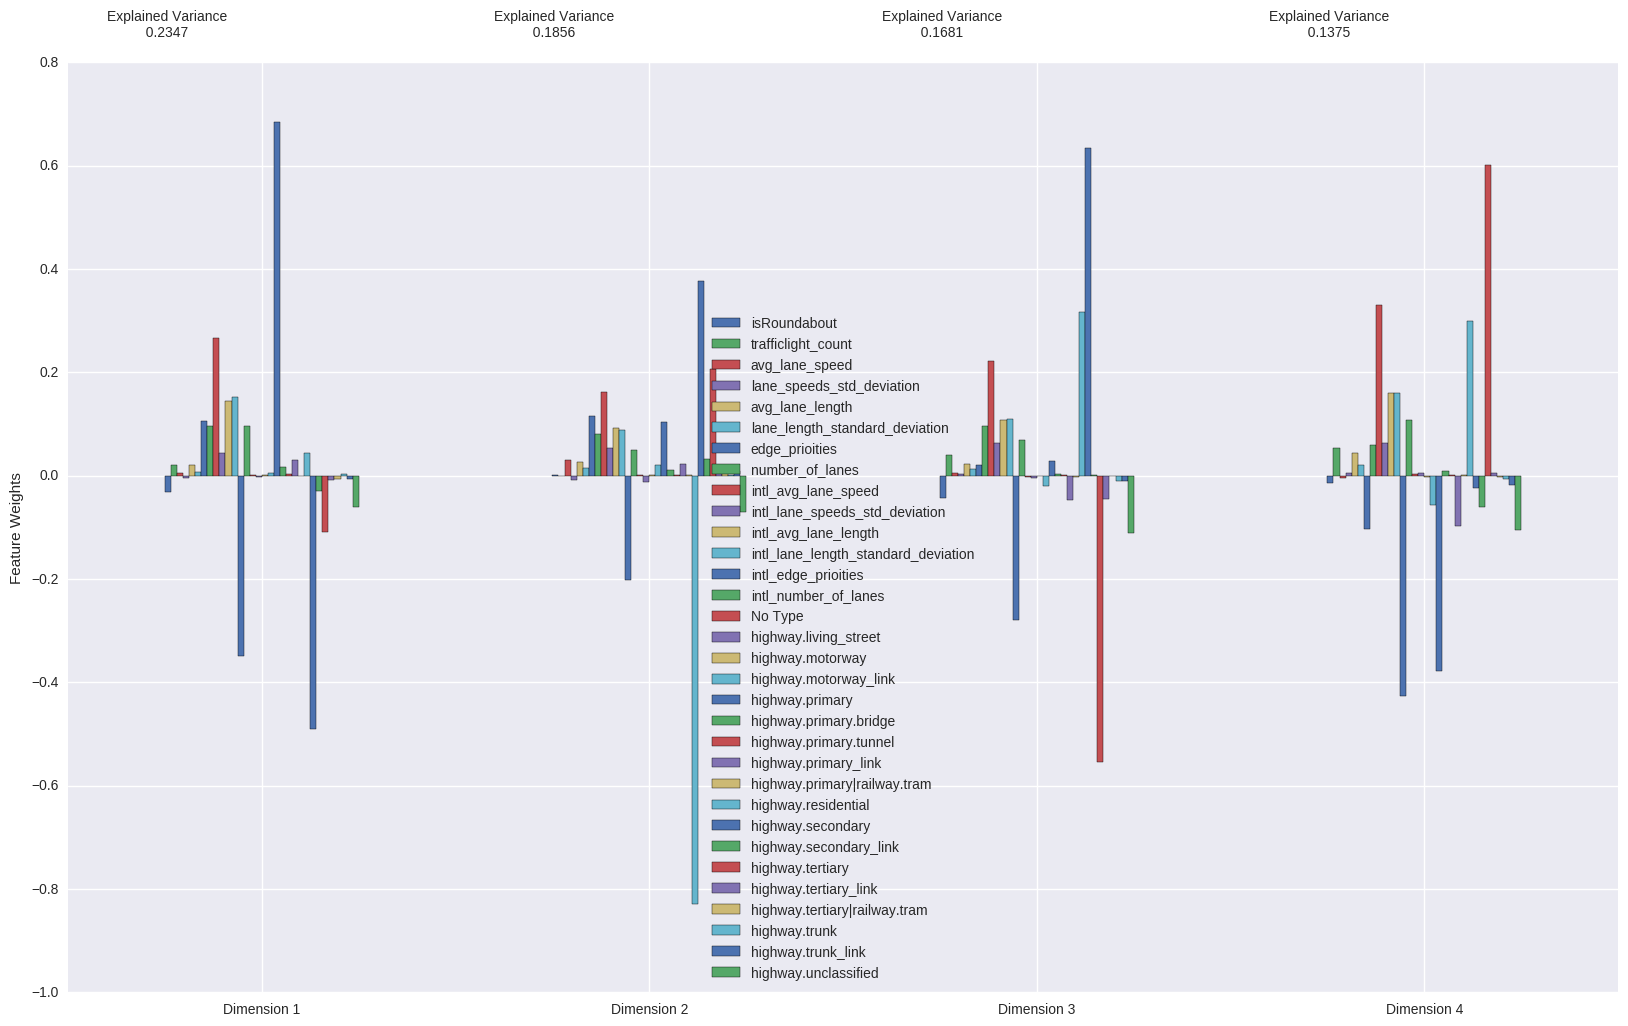

In [9]:
pca_analyse (scaled_combined_dataset)

#### 4.2.3 Analysis of PCA with RobustScaler
For the robust scaler, the variance explained in 3 dimensions will be enough. Just out of curiosity, I will include the 4th dimension for further analysis nontheless.

Dimension 1    0.4354
Dimension 2    0.7068
Dimension 3    0.7785
Dimension 4    0.8354
Name: Explained Variance, dtype: float64


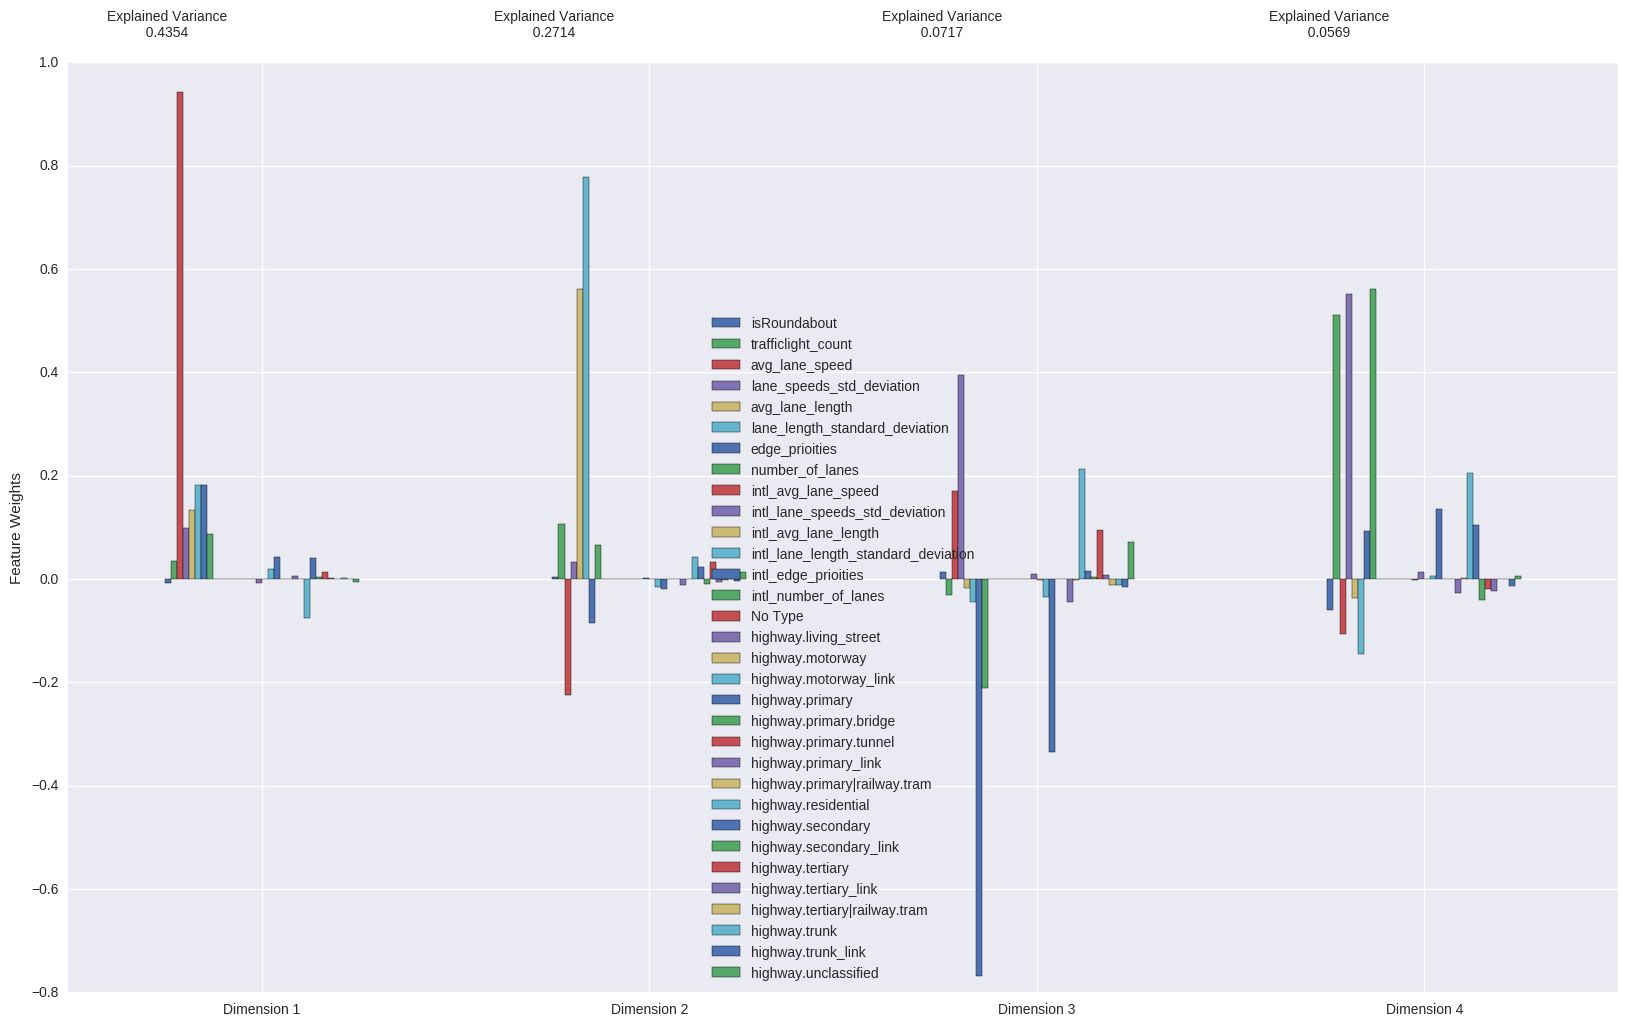

In [10]:
pca_analyse (scaled_cgn_dataset_robust)

Dimension 1    0.3344
Dimension 2    0.5970
Dimension 3    0.7918
Dimension 4    0.8433
Name: Explained Variance, dtype: float64


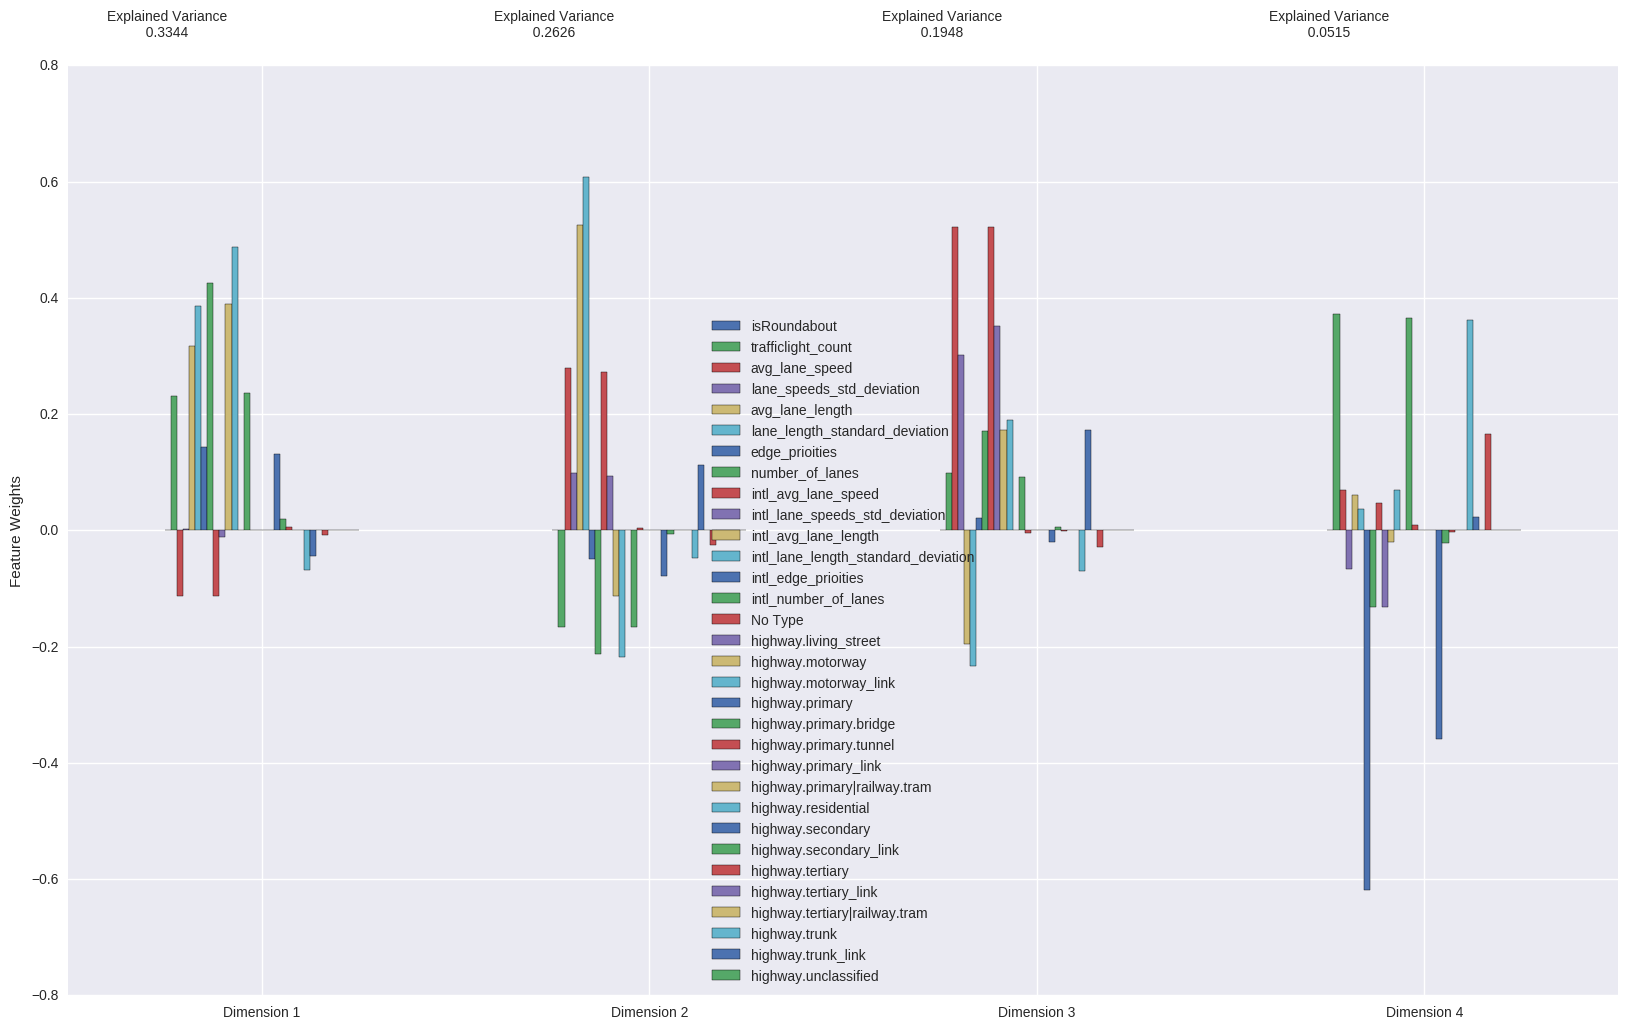

In [11]:
pca_analyse (scaled_lust_dataset_robust)

Dimension 1    0.8279
Dimension 2    0.8790
Dimension 3    0.9159
Dimension 4    0.9429
Name: Explained Variance, dtype: float64


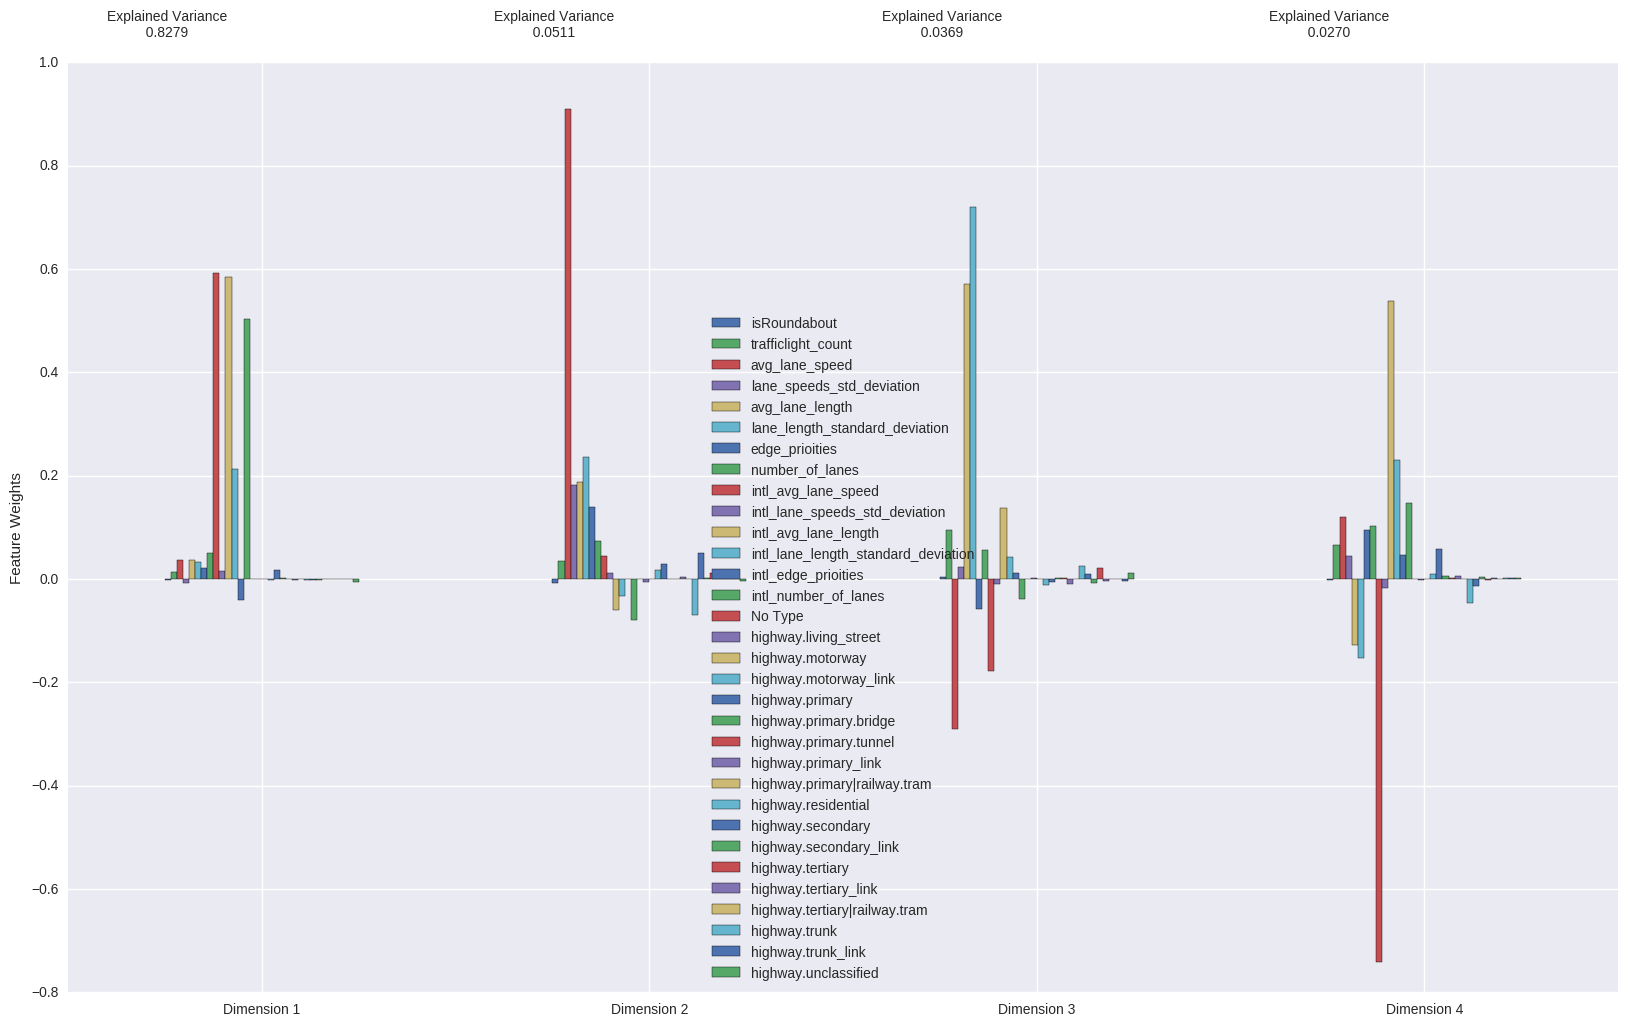

In [12]:
pca_analyse (scaled_combined_dataset_robust)

#### 4.2.4 Apply PCA for 3 and 4 dimensions on robust and abs scaled datasets


In [13]:
# Fit PCA to the good data using three dimensions, for both scalers
cmb_pca =  PCA(n_components=3).fit(scaled_combined_dataset)
cgn_pca =  PCA(n_components=3).fit(scaled_cgn_dataset)
lst_pca =  PCA(n_components=3).fit(scaled_lust_dataset)
cmb_pca_robust = PCA(n_components=3).fit(scaled_combined_dataset_robust)
cgn_pca_robust = PCA(n_components=3).fit(scaled_cgn_dataset_robust)
lst_pca_robust = PCA(n_components=3).fit(scaled_lust_dataset_robust)

# Apply a PCA transformation the good data
cmb_reduced_data = cmb_pca.transform(scaled_combined_dataset)
cgn_reduced_data = cgn_pca.transform(scaled_cgn_dataset)
lst_reduced_data = lst_pca.transform(scaled_lust_dataset)

cmb_reduced_data_robust = cmb_pca_robust.transform(scaled_combined_dataset_robust)
cgn_reduced_data_robust = cgn_pca_robust.transform(scaled_cgn_dataset_robust)
lst_reduced_data_robust = lst_pca_robust.transform(scaled_lust_dataset_robust)


# Create DataFrames 
reduced_scaled_combined_dataset = pd.DataFrame(cmb_reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_cgn_dataset = pd.DataFrame(cgn_reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_lust_dataset = pd.DataFrame(lst_reduced_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

reduced_scaled_combined_dataset_robust = pd.DataFrame(cmb_reduced_data_robust, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_cgn_dataset_robust = pd.DataFrame(cgn_reduced_data_robust, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])
reduced_scaled_lust_dataset_robust = pd.DataFrame(lst_reduced_data_robust, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

In [14]:
# Fit PCA to the good data using 4 dimensions, using both scalers
cmb_pca4 =  PCA(n_components=4).fit(scaled_combined_dataset)
cgn_pca4 =  PCA(n_components=4).fit(scaled_cgn_dataset)
lst_pca4 =  PCA(n_components=4).fit(scaled_lust_dataset)

cmb_pca_robust4 = PCA(n_components=4).fit(scaled_combined_dataset_robust)
cgn_pca_robust4 = PCA(n_components=4).fit(scaled_cgn_dataset_robust)
lst_pca_robust4 = PCA(n_components=4).fit(scaled_lust_dataset_robust)

# Apply a PCA transformation the good data using 4 dimensions, using both scalers
cmb_reduced_data4 = cmb_pca4.transform(scaled_combined_dataset)
cgn_reduced_data4 = cgn_pca4.transform(scaled_cgn_dataset)
lst_reduced_data4 = lst_pca4.transform(scaled_lust_dataset)

cmb_reduced_data_robust4 = cmb_pca_robust4.transform(scaled_combined_dataset_robust)
cgn_reduced_data_robust4 = cgn_pca_robust4.transform(scaled_cgn_dataset_robust)
lst_reduced_data_robust4 = lst_pca_robust4.transform(scaled_lust_dataset_robust)

# Create DataFrames for the reduced data
reduced_scaled_combined_dataset4 = pd.DataFrame(cmb_reduced_data4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_cgn_dataset4 = pd.DataFrame(cgn_reduced_data4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_lust_dataset4 = pd.DataFrame(lst_reduced_data4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])

reduced_scaled_combined_dataset_robust4 = pd.DataFrame(cmb_reduced_data_robust4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_cgn_dataset_robust4 = pd.DataFrame(cgn_reduced_data_robust4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])
reduced_scaled_lust_dataset_robust4 = pd.DataFrame(lst_reduced_data_robust4, columns = ['Dimension 1', 'Dimension 2','Dimension 3','Dimension 4'])

# 5 Apply Clustering

Clusters will be chosen by their silhouette_score. The clustering result with the highest score will be chosen for the evaluation in later chapters. 
The following tables indicate that the datasets scaled using the robust scaler perform significantly worse than the ones using the max_abs scaler. The silhouette_score values are about 0.3 for the robust scaler on the cgn and lust datasets while they are better than 0.8 for max_abs scaled datasets.  
This holds true for both dataset types, 3 dimensional and 4 dimensional reduced data.
The silhouette scores for 3 dimensional kpca-reduced datasets are about the same as for 3 dimensional pca-reduced datasets.

In [15]:
from sklearn import mixture
from sklearn.metrics import silhouette_score

def apply_clustering(reduced_data):
    covar_types = ['spherical', 'diag', 'tied', 'full']
    covar_type = covar_types[3]
    scores=[]
    best_preds=None
    best_centers=None
    best_score=0
    for n in range(2,40):    
        clusterer = mixture.GaussianMixture (n_components= n, covariance_type=covar_type, max_iter=100, random_state= 512*n).fit(reduced_data)
        preds = clusterer.predict(reduced_data)        
        centers = clusterer.means_
        score = silhouette_score(reduced_data, preds, metric='euclidean')
        if score>best_score:
            best_score=score
            best_preds=preds
            best_centers=centers
            #print "\tnew best cluster count {}".format(n)

        scores.append(score)        
    return (best_preds,best_centers, scores)
print "3d clustering for cgn..."
reduced_scaled_cgn_dataset_clusters= apply_clustering(reduced_scaled_cgn_dataset)
print "3d clustering for lust..."
reduced_scaled_lust_dataset_clusters= apply_clustering(reduced_scaled_lust_dataset)
print "3d clustering for both..."
reduced_scaled_combined_dataset_clusters= apply_clustering(reduced_scaled_combined_dataset)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters[2]),np.max(reduced_scaled_lust_dataset_clusters[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters[2])]],columns=['cgn_max', 'lust_max','combined_max'])
print "best values:"
display(max_table)
print "all values"
results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

3d clustering for cgn...
3d clustering for lust...
3d clustering for both...
best values:


cgn_max  lust_max  combined_max
0  0.930098  0.852228      0.884868

all values


cgn_scores  lust_scores  combined_scores
2     0.365428     0.358132         0.336001
3     0.406440     0.423903         0.376812
4     0.464201     0.505611         0.375599
5     0.536788     0.616659         0.497939
6     0.585177     0.668837         0.522984
7     0.621255     0.712932         0.546751
8     0.701862     0.725414         0.597778
9     0.734971     0.768720         0.580012
10    0.827608     0.797088         0.687035
11    0.887022     0.817668         0.679502
12    0.904464     0.837092         0.713609
13    0.917974     0.852228         0.776857
14    0.930098     0.699680         0.788119
15    0.912851     0.840425         0.789285
16    0.924975     0.791376         0.826113
17    0.859924     0.803968         0.815547
18    0.803449     0.748363         0.828732
19    0.791858     0.741864         0.847746
20    0.788472     0.715406         0.858450
21    0.777780     0.718331         0.866288
22    0.806718     0.686510         0.861235
23    0.776864     0.693882         0.882558
24    0.754132     0.651914         0.870681
25    0.738692     0.663946         0.883821
26    0.766474     0.649205         0.879265
27    0.685672     0.625396         0.877410
28    0.727857     0.655099         0.884868
29    0.715986     0.597382         0.883857
30    0.685031     0.631174         0.862982
31    0.679479     0.598901         0.854245
32    0.721477     0.616639         0.829174
33    0.681294     0.631933         0.830226
34    0.688749     0.573257         0.819231
35    0.660774     0.566102         0.808622
36    0.716031     0.550076         0.787125
37    0.695835     0.584363         0.807697
38    0.657798     0.552942         0.752852
39    0.653867     0.495149         0.754339

In [16]:
print "3d clustering for cgn(robust scaler)..."
reduced_scaled_cgn_dataset_clusters_robust= apply_clustering(reduced_scaled_cgn_dataset_robust)
print "3d clustering for lust(robust scaler)..."
reduced_scaled_lust_dataset_clusters_robust= apply_clustering(reduced_scaled_lust_dataset_robust)
print "3d clustering for both(robust scaler)..."
reduced_scaled_combined_dataset_clusters_robust= apply_clustering(reduced_scaled_combined_dataset_robust)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters_robust[2]),np.max(reduced_scaled_lust_dataset_clusters_robust[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters_robust[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters_robust[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters_robust[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters_robust[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

3d clustering for cgn(robust scaler)...
3d clustering for lust(robust scaler)...
3d clustering for both(robust scaler)...


cgn_max  lust_max  combined_max
0  0.330509  0.318991      0.846676

cgn_scores  lust_scores  combined_scores
2     0.260108     0.317374         0.846676
3     0.265382     0.252686         0.805965
4     0.330509     0.271133         0.378132
5     0.257035     0.206262         0.427113
6     0.196974     0.194428         0.294516
7     0.241381     0.204547         0.353862
8     0.255071     0.209391         0.335474
9     0.239715     0.300286         0.344892
10    0.224446     0.075929         0.339567
11    0.291692     0.134992         0.363904
12    0.291561     0.191928         0.348635
13    0.222812     0.136251         0.364327
14    0.221212     0.120524         0.366525
15    0.212479     0.202252         0.370650
16    0.226894     0.204102         0.375444
17    0.214155     0.051786         0.269057
18    0.238432     0.193654         0.286193
19    0.133088     0.213055         0.251770
20    0.174546     0.233222         0.289556
21    0.206412     0.226151         0.251488
22    0.130727     0.199182         0.271783
23    0.228272     0.232317         0.259409
24    0.113062     0.137482         0.289187
25    0.105805     0.303884         0.239736
26    0.089885     0.277440         0.293401
27    0.091952     0.288501         0.308837
28    0.154369     0.264022         0.285739
29    0.095131     0.288520         0.291299
30    0.104676     0.217603         0.258729
31    0.120185     0.283039         0.300246
32    0.145101     0.296426         0.317335
33    0.096226     0.217343         0.317312
34    0.174015     0.200488         0.299796
35    0.112644     0.275749         0.260873
36    0.095590     0.318991         0.299405
37    0.061879     0.268561         0.318612
38    0.126351     0.312657         0.329396
39    0.095772     0.315691         0.219087

In [17]:
print "4d clustering for cgn..."
reduced_scaled_cgn_dataset_clusters4= apply_clustering(reduced_scaled_cgn_dataset4)
print "4d clustering for lust..."
reduced_scaled_lust_dataset_clusters4= apply_clustering(reduced_scaled_lust_dataset4)
print "4d clustering for both..."
reduced_scaled_combined_dataset_clusters4= apply_clustering(reduced_scaled_combined_dataset4)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters4[2]),np.max(reduced_scaled_lust_dataset_clusters4[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters4[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters4[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters4[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters4[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

4d clustering for cgn...
4d clustering for lust...
4d clustering for both...


cgn_max  lust_max  combined_max
0  0.842051  0.785077      0.906964

cgn_scores  lust_scores  combined_scores
2     0.268422     0.360481         0.288465
3     0.377313     0.383253         0.348230
4     0.399893     0.413846         0.361626
5     0.449766     0.502743         0.381459
6     0.508915     0.510917         0.480101
7     0.590953     0.647072         0.467876
8     0.620926     0.658355         0.544133
9     0.678815     0.693011         0.551524
10    0.739899     0.691450         0.582401
11    0.748685     0.719057         0.711285
12    0.771624     0.749099         0.705405
13    0.787947     0.720346         0.735379
14    0.801477     0.784952         0.783647
15    0.819304     0.785077         0.818714
16    0.830441     0.700135         0.825778
17    0.820730     0.763527         0.849930
18    0.835352     0.720533         0.847742
19    0.785477     0.713667         0.865254
20    0.842051     0.713631         0.867450
21    0.841097     0.689482         0.878041
22    0.785567     0.633004         0.890346
23    0.782370     0.611975         0.893138
24    0.817165     0.647750         0.897815
25    0.820635     0.650888         0.906964
26    0.740850     0.602732         0.899376
27    0.730401     0.571125         0.887695
28    0.696359     0.585324         0.902430
29    0.667147     0.507178         0.893331
30    0.661236     0.563260         0.843301
31    0.632376     0.546464         0.826091
32    0.671294     0.552693         0.876340
33    0.741201     0.548151         0.818311
34    0.594624     0.539787         0.801792
35    0.599173     0.521730         0.790281
36    0.534687     0.527993         0.800113
37    0.572218     0.518635         0.791635
38    0.572449     0.550437         0.779487
39    0.544714     0.514808         0.757502

In [18]:
print "4d clustering for cgn(robust scaler)..."
reduced_scaled_cgn_dataset_clusters_robust4= apply_clustering(reduced_scaled_cgn_dataset_robust4)
print "4d clustering for lust(robust scaler)..."
reduced_scaled_lust_dataset_clusters_robust4= apply_clustering(reduced_scaled_lust_dataset_robust4)
print "4d clustering for both(robust scaler)..."
reduced_scaled_combined_dataset_clusters_robust4= apply_clustering(reduced_scaled_combined_dataset_robust4)

max_table= pd.DataFrame([[np.max(reduced_scaled_cgn_dataset_clusters_robust4[2]),np.max(reduced_scaled_lust_dataset_clusters_robust4[2]) ,
             np.max(reduced_scaled_combined_dataset_clusters_robust4[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table= pd.DataFrame()
results_table["cgn_scores"]=reduced_scaled_cgn_dataset_clusters_robust4[2]
results_table["lust_scores"]=reduced_scaled_lust_dataset_clusters_robust4[2]
results_table["combined_scores"]=reduced_scaled_combined_dataset_clusters_robust4[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

4d clustering for cgn(robust scaler)...
4d clustering for lust(robust scaler)...
4d clustering for both(robust scaler)...


cgn_max  lust_max  combined_max
0  0.28796  0.334662      0.857091

cgn_scores  lust_scores  combined_scores
2     0.256625     0.293353         0.857091
3     0.287960     0.256864         0.801730
4     0.218564     0.257924         0.372695
5     0.238574     0.202800         0.282058
6     0.264918     0.192244         0.281149
7     0.221756     0.229485         0.300090
8     0.231846     0.221905         0.343390
9     0.261890     0.215311         0.350321
10    0.245346     0.222784         0.336178
11    0.224655     0.237722         0.237467
12    0.251368     0.185383         0.327900
13    0.158437     0.169532         0.321737
14    0.179385     0.237226         0.339654
15    0.150626     0.234874         0.311330
16    0.207373     0.290274         0.331816
17    0.205416     0.230031         0.359741
18    0.182034     0.235341         0.216416
19    0.187436     0.252414         0.245348
20    0.144631     0.278130         0.223636
21    0.182051     0.218629         0.262246
22    0.096898     0.255702         0.216548
23    0.128015     0.283800         0.271924
24    0.098895     0.254139         0.246271
25    0.180495     0.262250         0.305313
26    0.171010     0.267694         0.208064
27    0.099899     0.270789         0.280398
28    0.072691     0.293119         0.258505
29    0.102502     0.286778         0.288389
30    0.148167     0.265902         0.324702
31    0.076825     0.205184         0.313760
32    0.092975     0.216521         0.320052
33    0.091356     0.276890         0.257979
34    0.126090     0.312123         0.320116
35    0.106934     0.314760         0.302416
36    0.105337     0.299649         0.272477
37    0.071105     0.273371         0.254080
38    0.073374     0.291910         0.301964
39    0.089597     0.334662         0.213930

In [19]:
from sklearn import cluster

def apply_clustering_on_kpcasets(reduced_data):
    covar_types = ['spherical', 'diag', 'tied', 'full']
    covar_type = covar_types[3]
    scores=[]
    best_preds=None
    best_centers=None
    best_score=0
    
    for n in range(2,40):    
        clusterer = cluster.KMeans(n_clusters= n, max_iter=300, random_state= 512*n).fit(reduced_data)
        preds = clusterer.predict(reduced_data)        
        centers = clusterer.cluster_centers_
        
        try:
            score = silhouette_score(reduced_data, preds, metric='euclidean')
        except ValueError:
            scores.append(0)
            continue
        if score>best_score:
            best_score=score
            best_preds=preds
            best_centers=centers
            #print "\tnew best cluster count {}".format(n)

        scores.append(score)        
    return (best_preds,best_centers, scores)

kpca_reduced_scaled_cgn_dataset_clusters= apply_clustering_on_kpcasets(kpca_reduced_scaled_cgn_dataset)
kpca_reduced_scaled_lust_dataset_clusters= apply_clustering_on_kpcasets(kpca_reduced_scaled_lust_dataset)
kpca_reduced_scaled_combined_dataset_clusters= apply_clustering_on_kpcasets(kpca_reduced_scaled_combined_dataset)

max_table= pd.DataFrame([[np.max(kpca_reduced_scaled_cgn_dataset_clusters[2]),np.max(kpca_reduced_scaled_lust_dataset_clusters[2]) ,
             np.max(kpca_reduced_scaled_combined_dataset_clusters[2])]],columns=['cgn_max', 'lust_max','combined_max'])
display(max_table)

results_table=pd.DataFrame()
results_table["cgn_scores"]=kpca_reduced_scaled_cgn_dataset_clusters[2]
results_table["lust_scores"]=kpca_reduced_scaled_lust_dataset_clusters[2]
results_table["combined_scores"]=kpca_reduced_scaled_combined_dataset_clusters[2]
results_table.index= np.arange(2, len(results_table)+2)
display(results_table)

cgn_max  lust_max  combined_max
0  0.934817  0.857501      0.899833

cgn_scores  lust_scores  combined_scores
2     0.365564     0.393230         0.351147
3     0.422410     0.455830         0.381069
4     0.497941     0.537019         0.434768
5     0.550837     0.619529         0.497584
6     0.639826     0.668863         0.549527
7     0.683531     0.720587         0.584024
8     0.751734     0.747986         0.625916
9     0.801667     0.770061         0.652131
10    0.857345     0.800593         0.691653
11    0.888561     0.821155         0.714404
12    0.905958     0.840783         0.749786
13    0.919293     0.855824         0.778624
14    0.931458     0.857501         0.810749
15    0.934817     0.836746         0.831714
16    0.928627     0.831570         0.843965
17    0.878960     0.818076         0.850535
18    0.840670     0.792314         0.858811
19    0.810185     0.774415         0.867606
20    0.806993     0.746166         0.872703
21    0.813184     0.705153         0.875267
22    0.783227     0.705370         0.880767
23    0.760559     0.696896         0.887216
24    0.757974     0.738326         0.894570
25    0.728031     0.652389         0.898147
26    0.728638     0.702082         0.899833
27    0.739262     0.673073         0.896132
28    0.737059     0.659412         0.898184
29    0.697727     0.634753         0.896930
30    0.705501     0.633432         0.869640
31    0.703104     0.626838         0.857326
32    0.688527     0.609787         0.839445
33    0.685385     0.617002         0.840479
34    0.655692     0.640262         0.791851
35    0.633015     0.598471         0.821918
36    0.669949     0.574521         0.762993
37    0.696460     0.609827         0.745221
38    0.595955     0.592694         0.734670
39    0.663216     0.583329         0.749631

# 6  Analysis of Results

## 6.1 Graphical Analysis
The following 3D plots will give further insight into the found clusters. Currently it seems as if the max_abs scaled datasets with 3 dimensions and PCA are the best choice. 

### 6.1.1 MaxAbs Scaler Based Clusters
 

#### Cologne-Dataset 3 Dimensions, robust and max_abs scalers
The PCA plot for max_abs scaling shows some very well defined clear clusters. 
The three clusters of the robust scaler PCA have on very small distant cluster and two large, not clearly separated clusters. 

Cologne MaxAbs Scaler PCA 3 Dimension Clusters


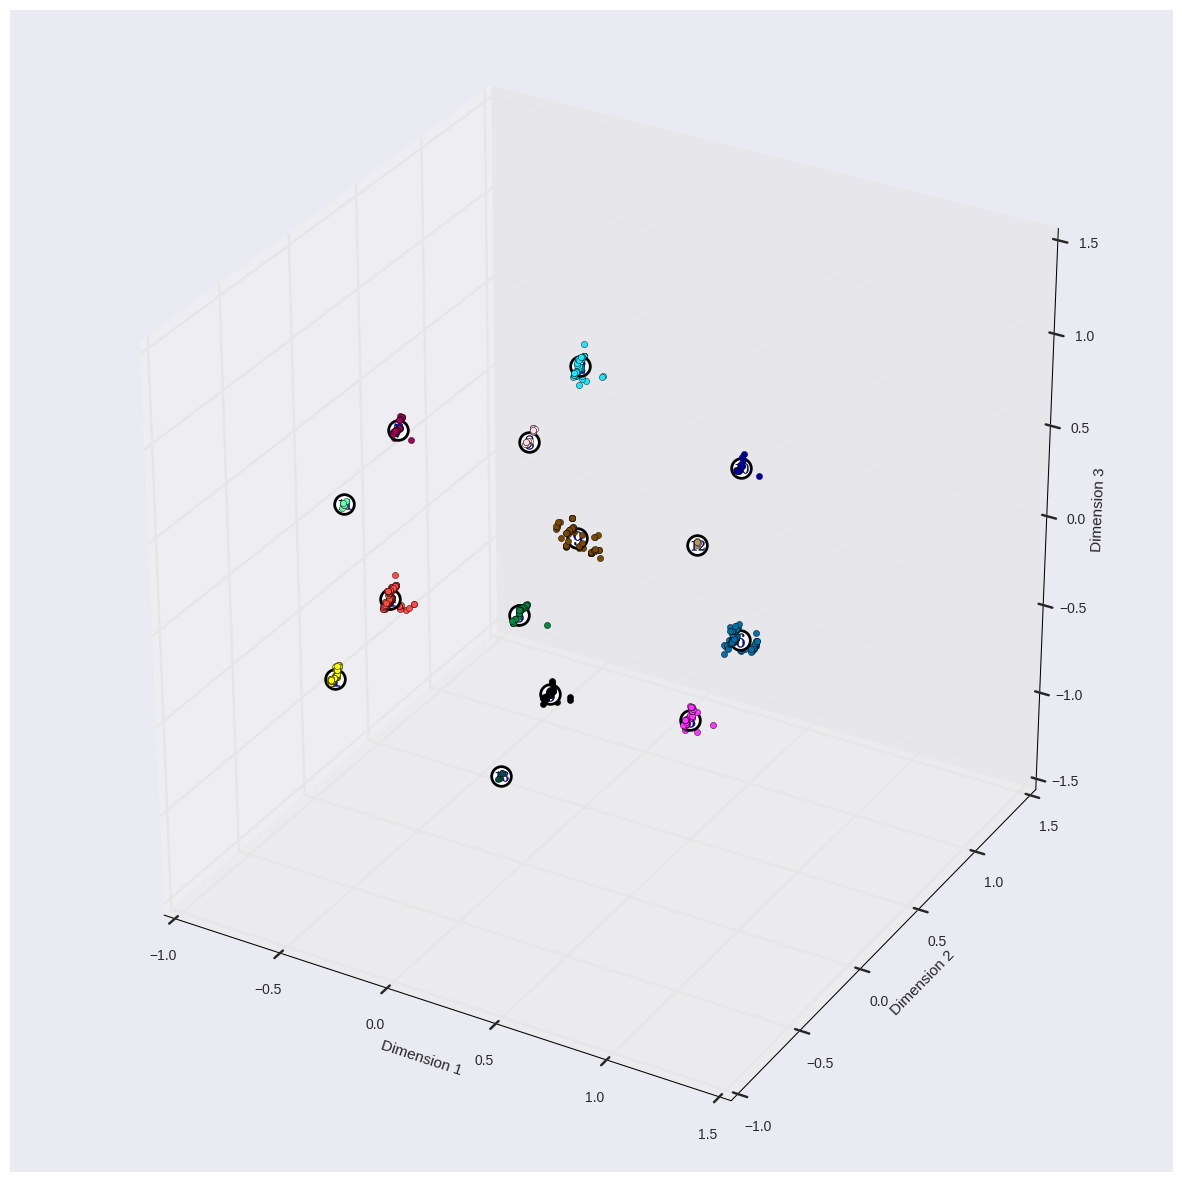

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import colormap as cmap

def show_3d_plot(reduced_data, centers, preds):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    n = 100
    for i,series in enumerate(reduced_data.iterrows()):
        p=preds[i]
        xs = series[1].get(0)
        ys = series[1].get(1)
        zs = series[1].get(2)

        ax.scatter(xs, ys, zs, c=cmap.colors[p])

    for i, series in enumerate(centers):    
        ax.scatter(series[0],series[1],series[2], c = 'white', edgecolors = 'black', \
        alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(series[0],series[1],series[2], marker='$%d$'%(i), alpha = 1, s=100);

    ax.set_xlabel(reduced_data.columns[0])
    ax.set_ylabel(reduced_data.columns[1])
    ax.set_zlabel(reduced_data.columns[2])

    plt.show()
print "Cologne MaxAbs Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_cgn_dataset,reduced_scaled_cgn_dataset_clusters[1],reduced_scaled_cgn_dataset_clusters[0])

Cologne- Robust Scaler PCA 3 Dimension Clusters


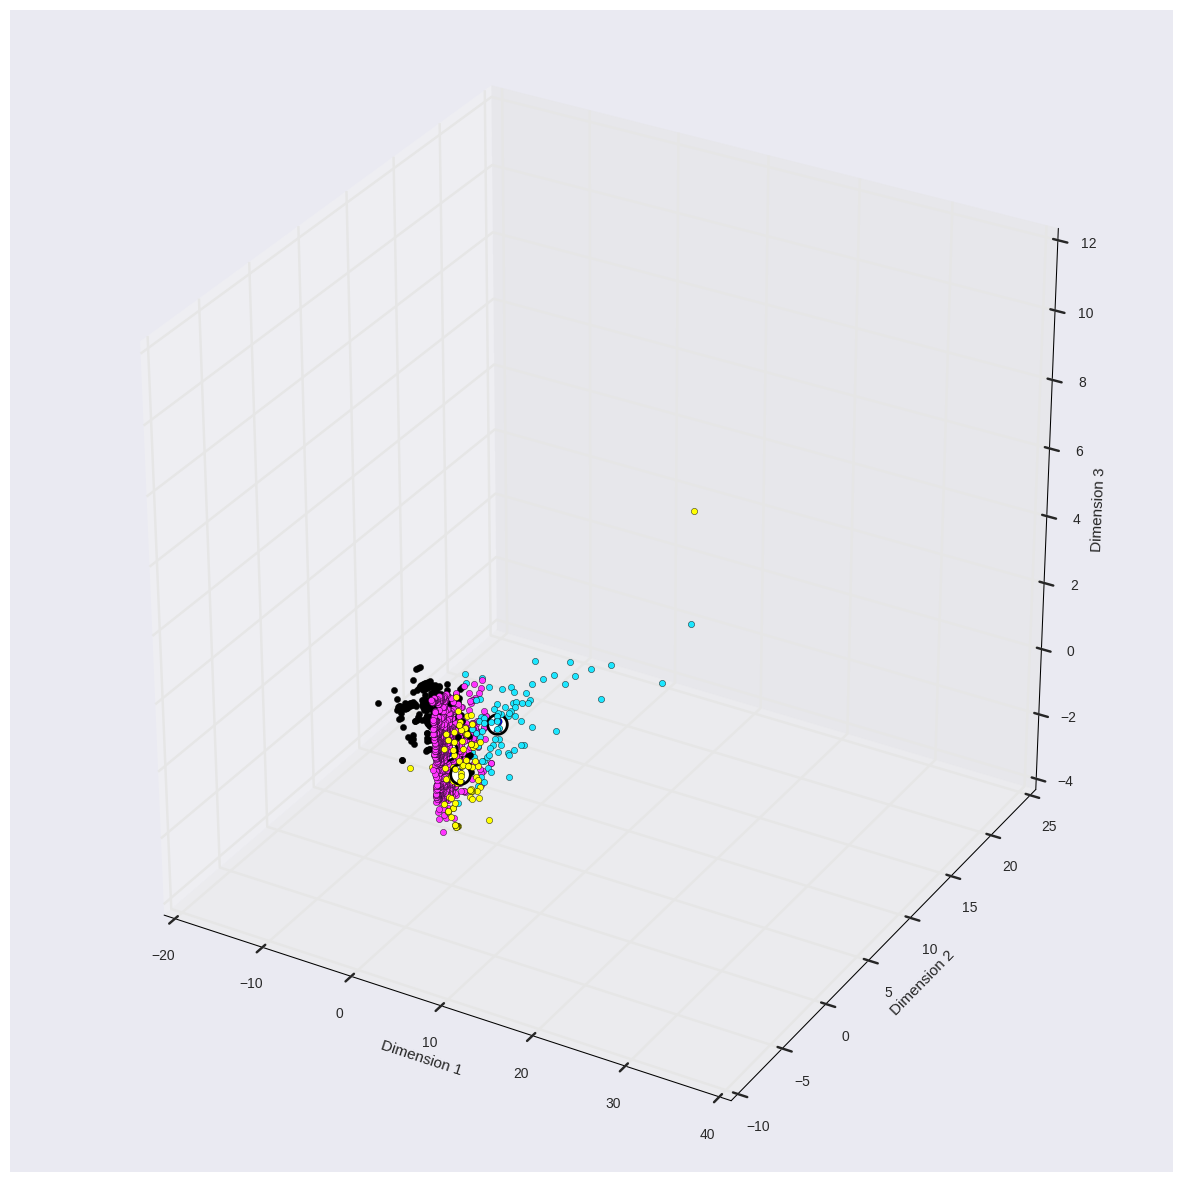

In [21]:
print "Cologne- Robust Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_cgn_dataset_robust,reduced_scaled_cgn_dataset_clusters_robust[1],reduced_scaled_cgn_dataset_clusters_robust[0])

#### LUst-Dataset 3 Dimensions, robust and max_abs scalers
For the LUst dataset a similar result can be seen. The max_abs scaled dataset results in some very well defined, separated clusters. While the robust_scaler dataset produces many intertwined clusters. 

Lust- max_abs Scaler PCA 3 Dimension Clusters


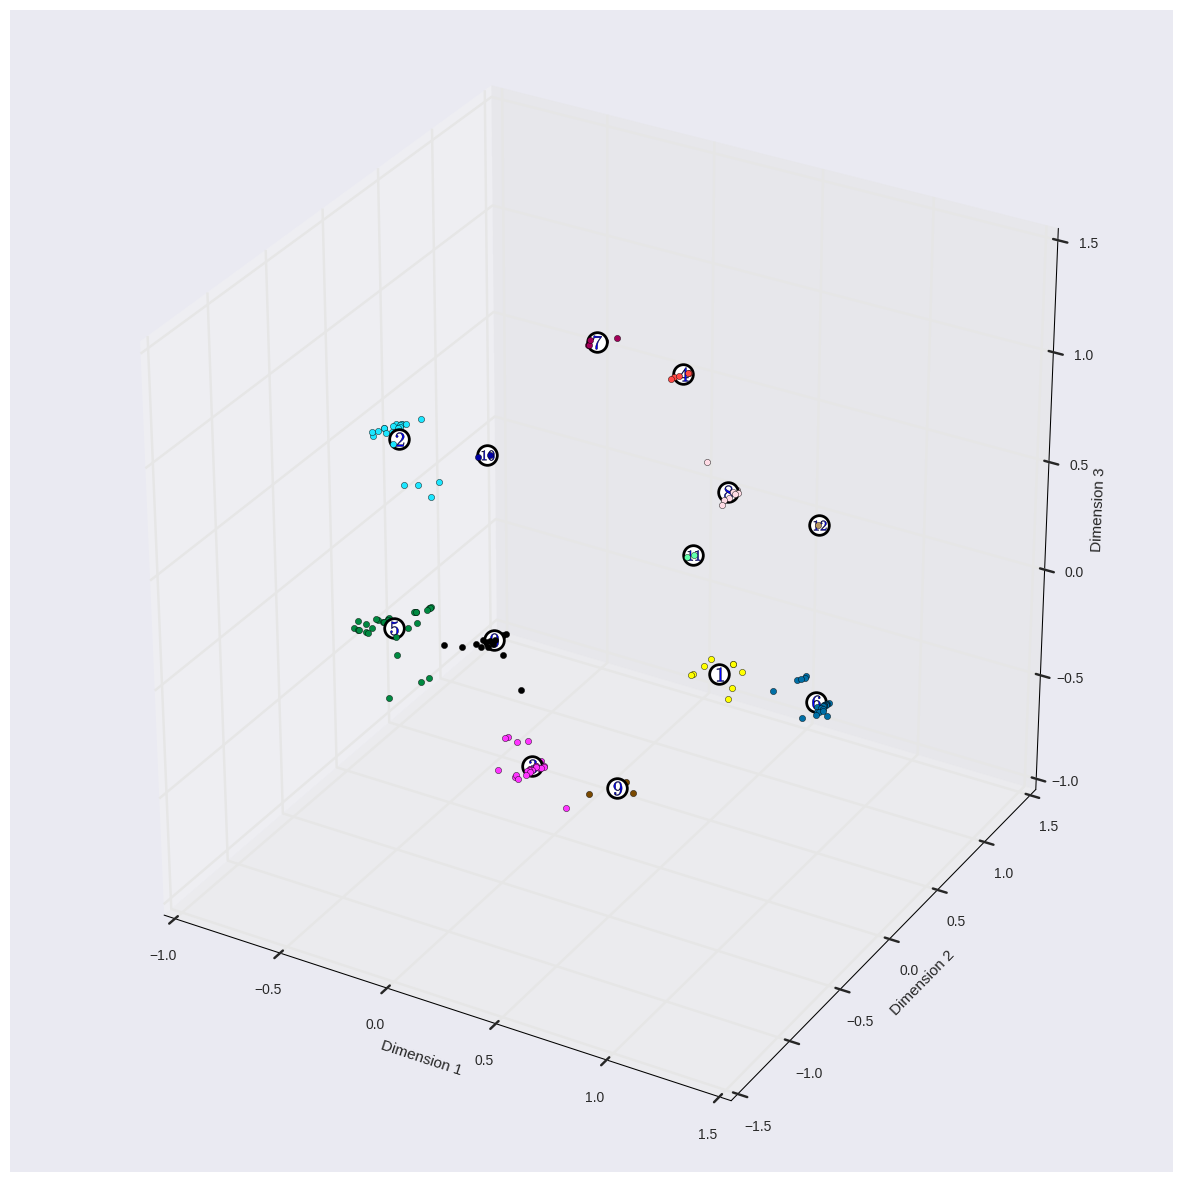

In [22]:
print "Lust- max_abs Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_lust_dataset,reduced_scaled_lust_dataset_clusters[1],reduced_scaled_lust_dataset_clusters[0])

Lust- Robust Scaler PCA 3 Dimension Clusters


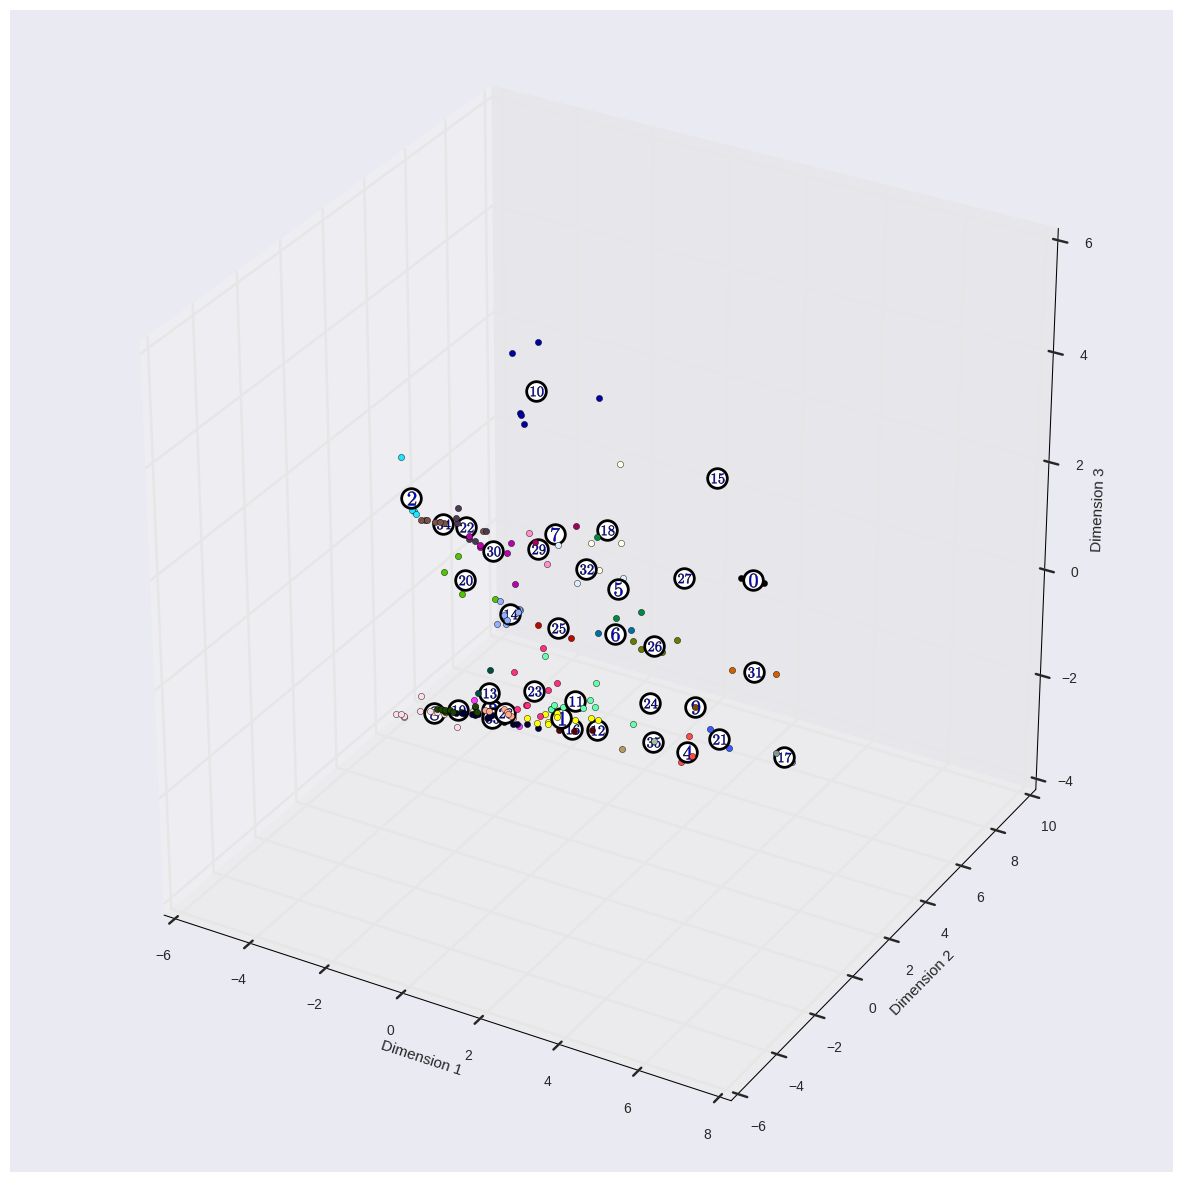

In [23]:
print "Lust- Robust Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_lust_dataset_robust,reduced_scaled_lust_dataset_clusters_robust[1],reduced_scaled_lust_dataset_clusters_robust[0])

#### Combined-Dataset 3 Dimensions, robust and max_abs scalers
The following two plots are created using the combined dataset. The result is basically the same as above. The max_abs scaler seems to produce a better dataset for clustering. 

Combined- max_abs Scaler PCA 3 Dimension Clusters


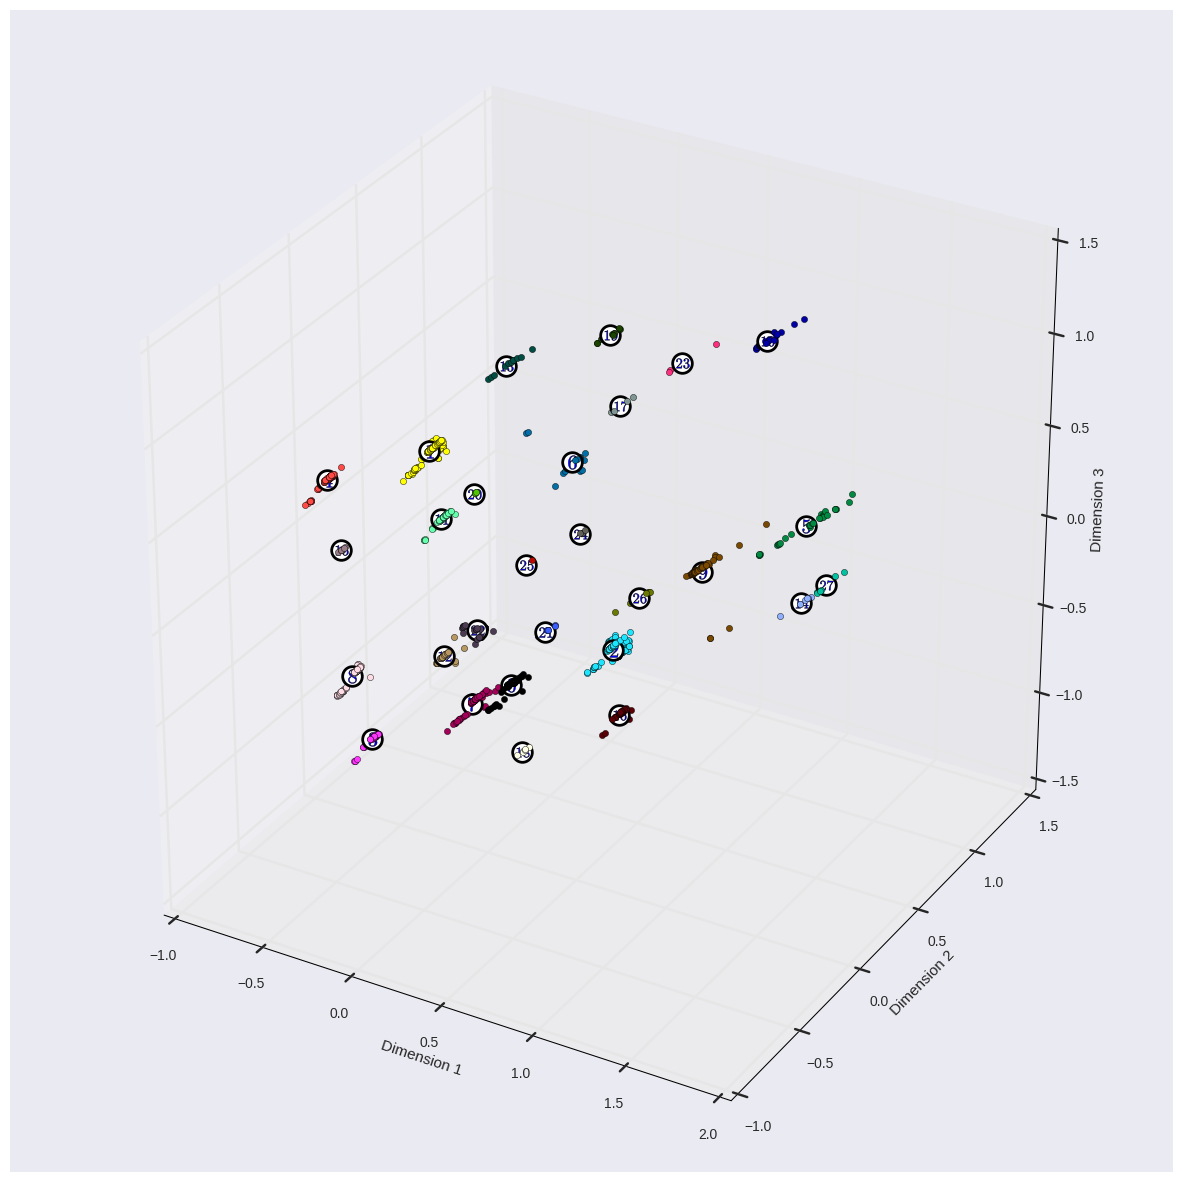

In [24]:
print "Combined- max_abs Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_combined_dataset,reduced_scaled_combined_dataset_clusters[1],reduced_scaled_combined_dataset_clusters[0])

Combined- Robust Scaler PCA 3 Dimension Clusters


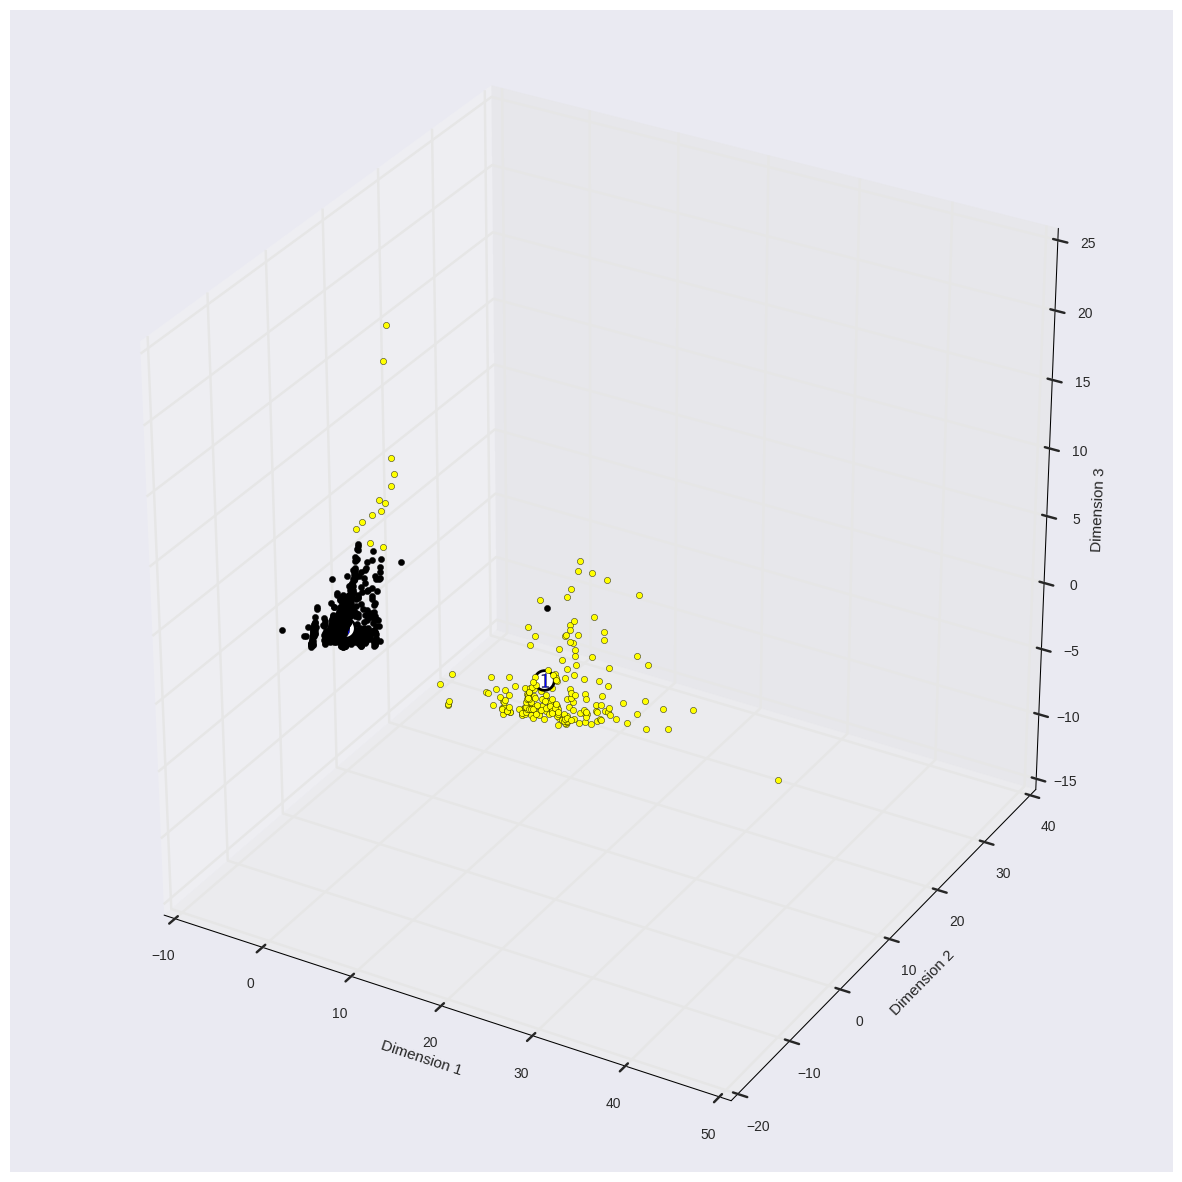

In [25]:
print "Combined- Robust Scaler PCA 3 Dimension Clusters"
show_3d_plot(reduced_scaled_combined_dataset_robust,reduced_scaled_combined_dataset_clusters_robust[1],reduced_scaled_combined_dataset_clusters_robust[0])

#### Cluster center visualization
This seems to be an indicator for an answer to the initial question. It seems that the clusters of the different datasets do not resemble each other very much. Some patterns of the different cluster centers position seem similar, but it looks more like chance. 

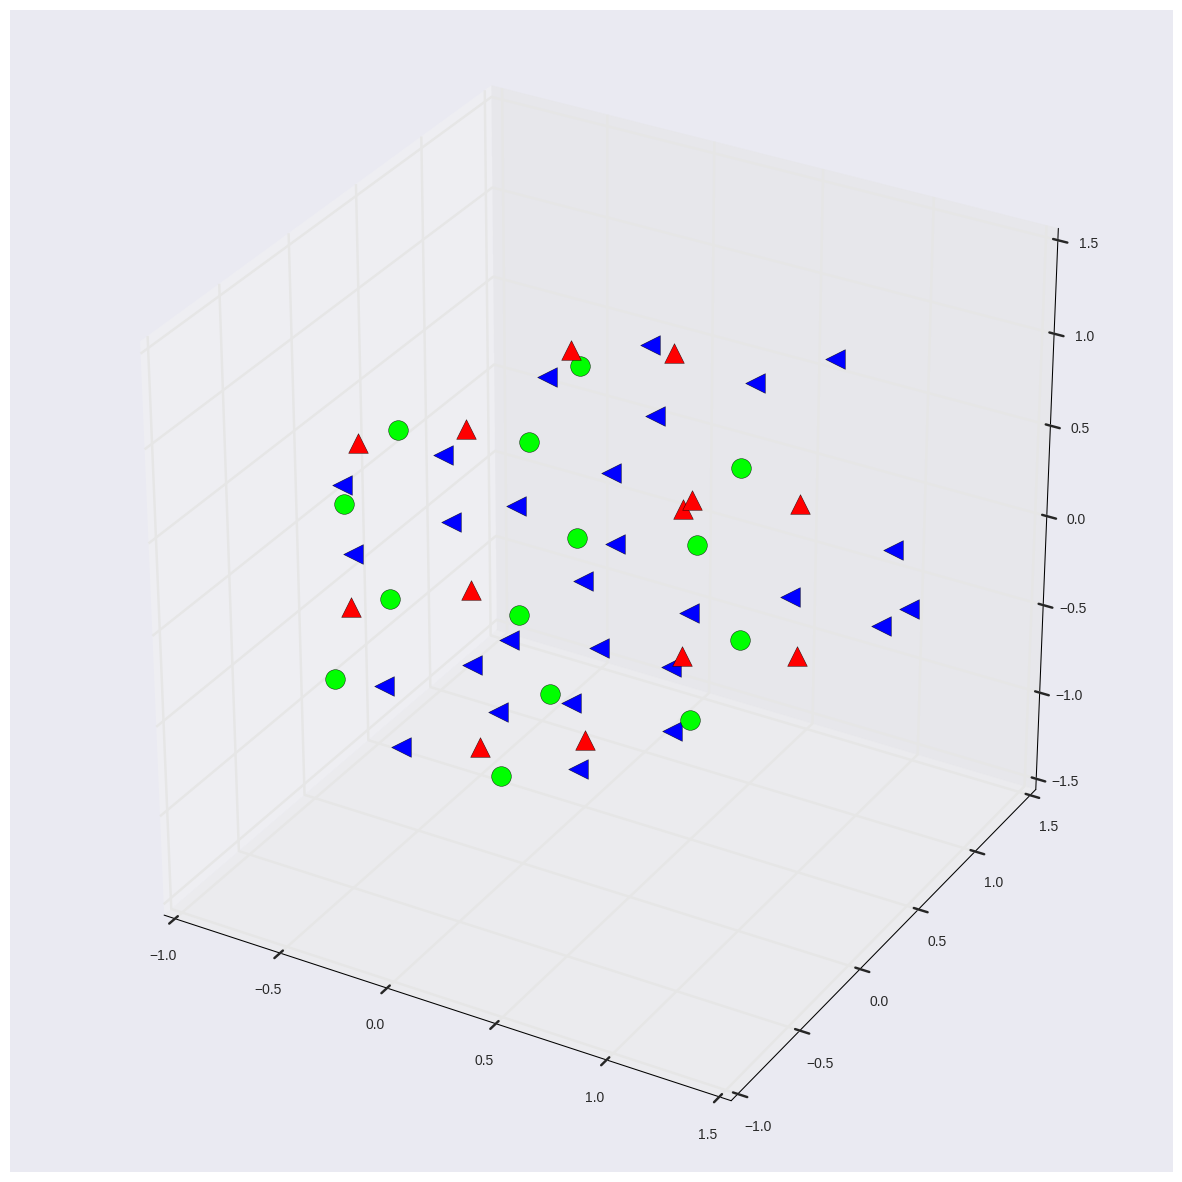

cgn centers:14 (green dots)
lust centers:13 (red triangles)
combined centers:28 (blue triangles)


In [26]:
def show_3d_plot_centers(centers, m, centers1, m1,centers2, m2):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    n = 100

    for i, series in enumerate(centers):    
        ax.scatter(series[0],series[1],series[2], c = '#00ff00',  \
        marker = m, s=200);
        
    for i, series in enumerate(centers1):    
        ax.scatter(series[0],series[1],series[2], c = '#ff0000',  \
        marker = m1, s=200);
    
    for i, series in enumerate(centers2):    
        ax.scatter(series[0],series[1],series[2], c = '#0000ff',  \
        marker = m2, s=200);

    plt.show()

show_3d_plot_centers(reduced_scaled_cgn_dataset_clusters[1],'o',reduced_scaled_lust_dataset_clusters[1],'^',reduced_scaled_combined_dataset_clusters[1],'<')

print "cgn centers:{} (green dots)".format(len(reduced_scaled_cgn_dataset_clusters[1]))
print "lust centers:{} (red triangles)".format(len(reduced_scaled_lust_dataset_clusters[1]))
print "combined centers:{} (blue triangles)".format(len(reduced_scaled_combined_dataset_clusters[1]))


#### KPCA clustering results
The results for KPCA look alot like the ones for PCA. One difference is that the scale is smaller than with PCA.
Other than that, the differences seem not to be significant. 

kpca cgn


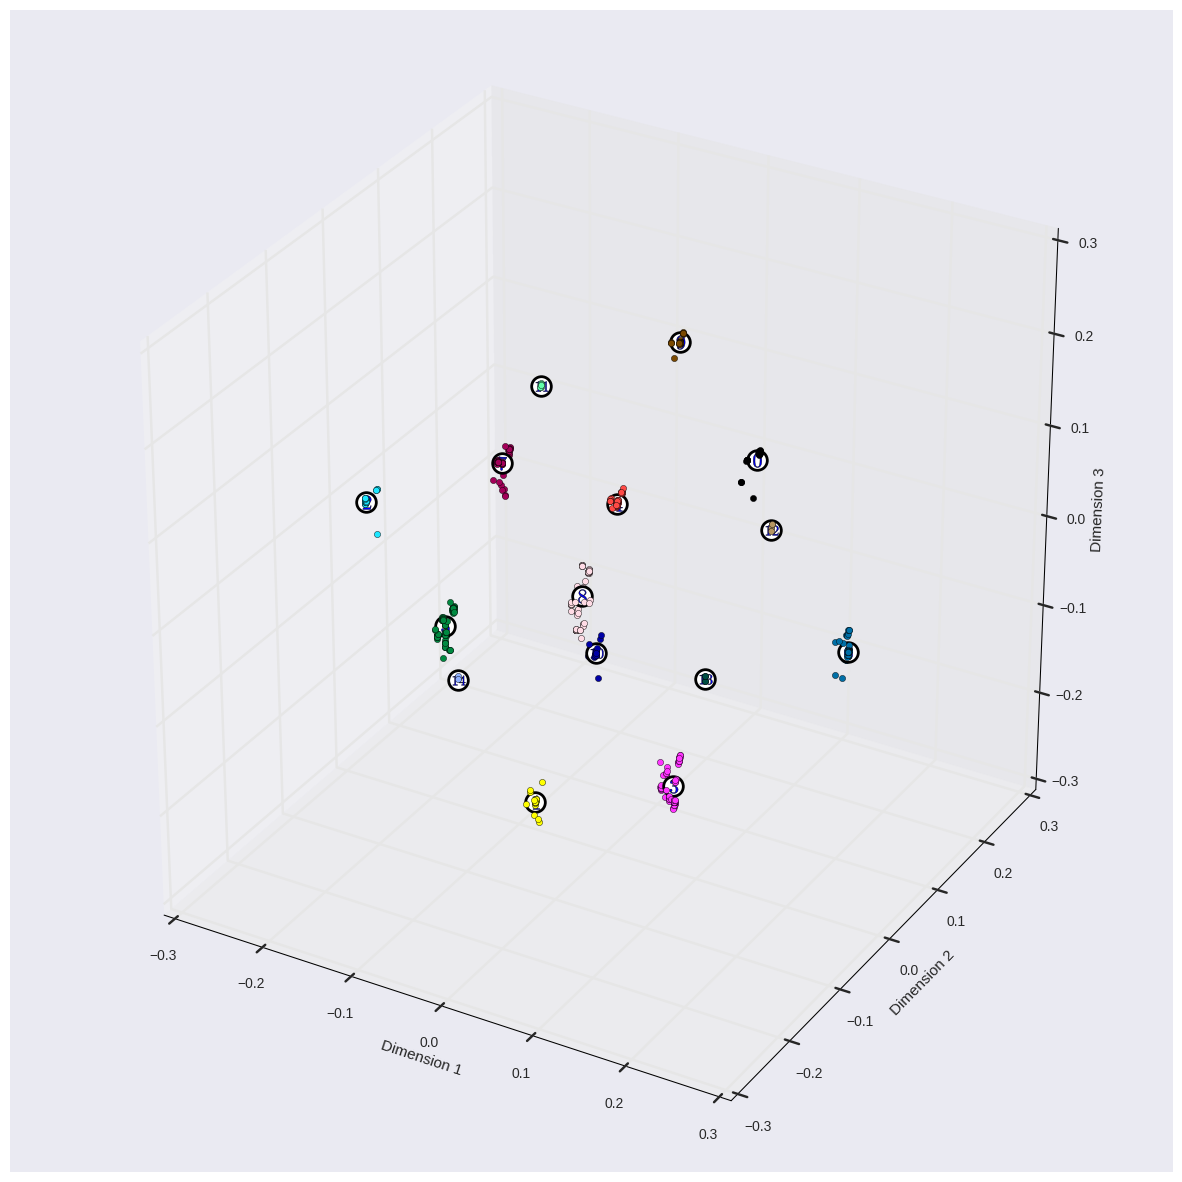

In [27]:
print ("kpca cgn")
show_3d_plot(kpca_reduced_scaled_cgn_dataset,kpca_reduced_scaled_cgn_dataset_clusters[1],kpca_reduced_scaled_cgn_dataset_clusters[0])

kpca lust


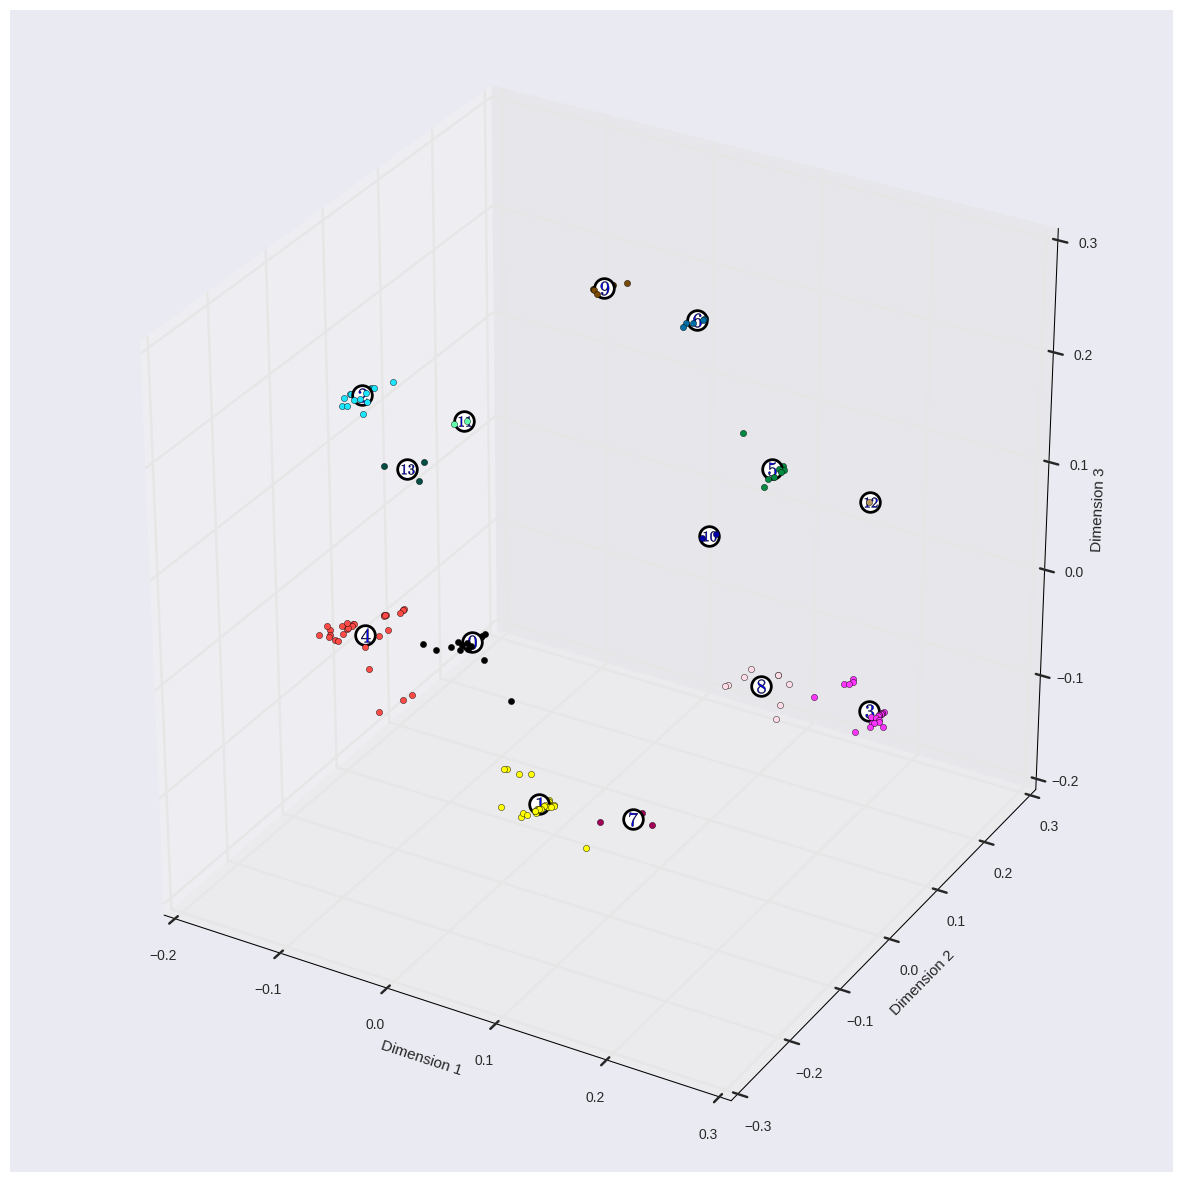

In [28]:
print ("kpca lust")
show_3d_plot(kpca_reduced_scaled_lust_dataset,kpca_reduced_scaled_lust_dataset_clusters[1],kpca_reduced_scaled_lust_dataset_clusters[0])

kpca combined


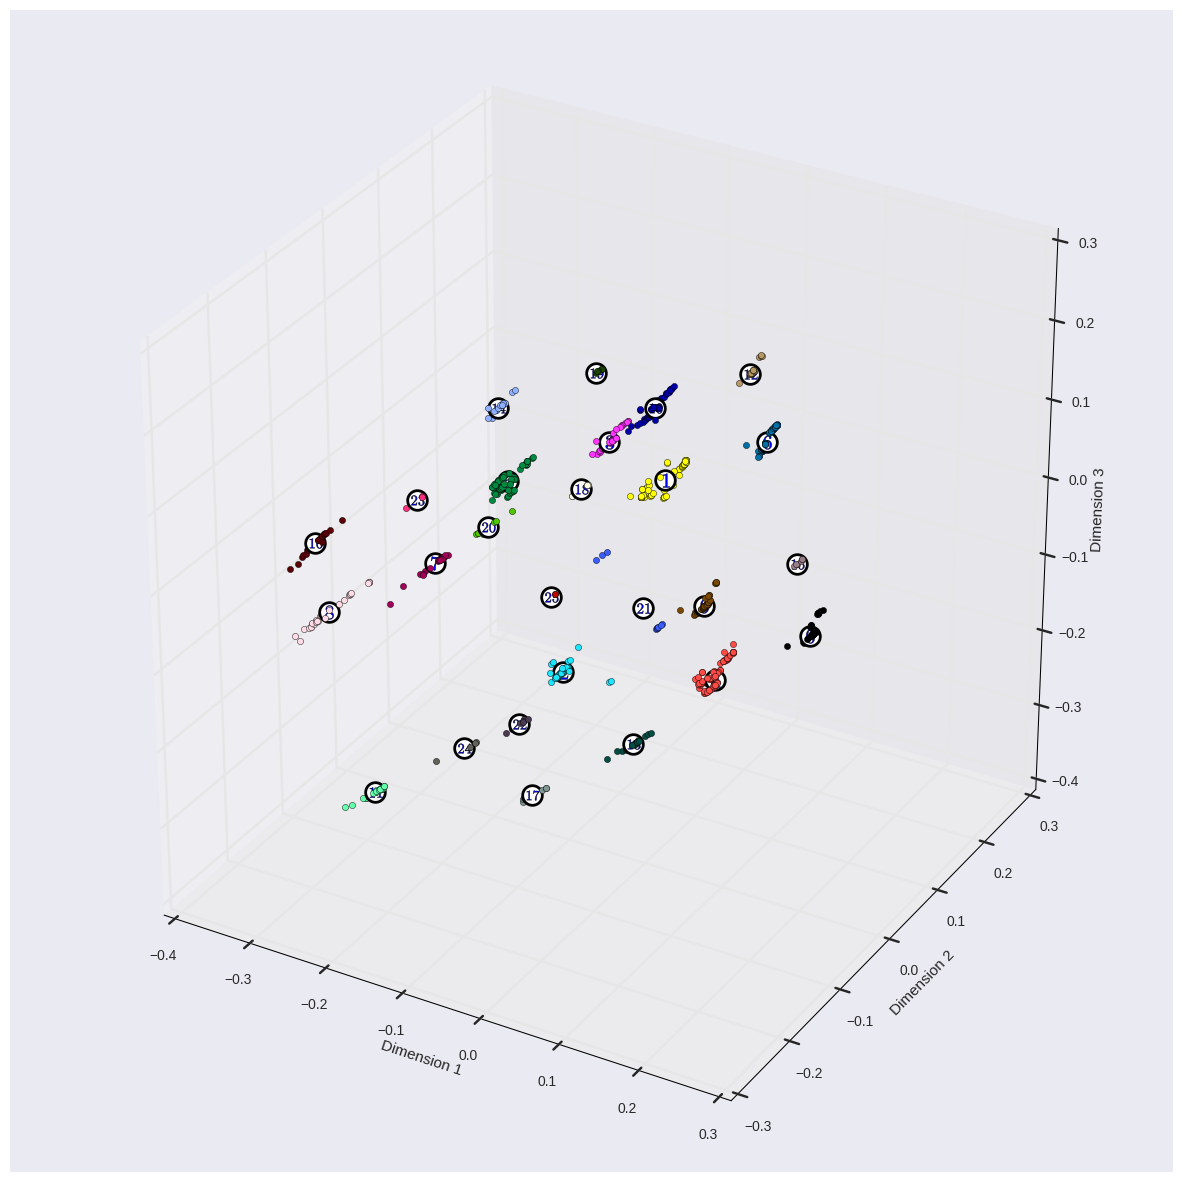

In [29]:
print ("kpca combined")
show_3d_plot(kpca_reduced_scaled_combined_dataset,kpca_reduced_scaled_combined_dataset_clusters[1],kpca_reduced_scaled_combined_dataset_clusters[0])

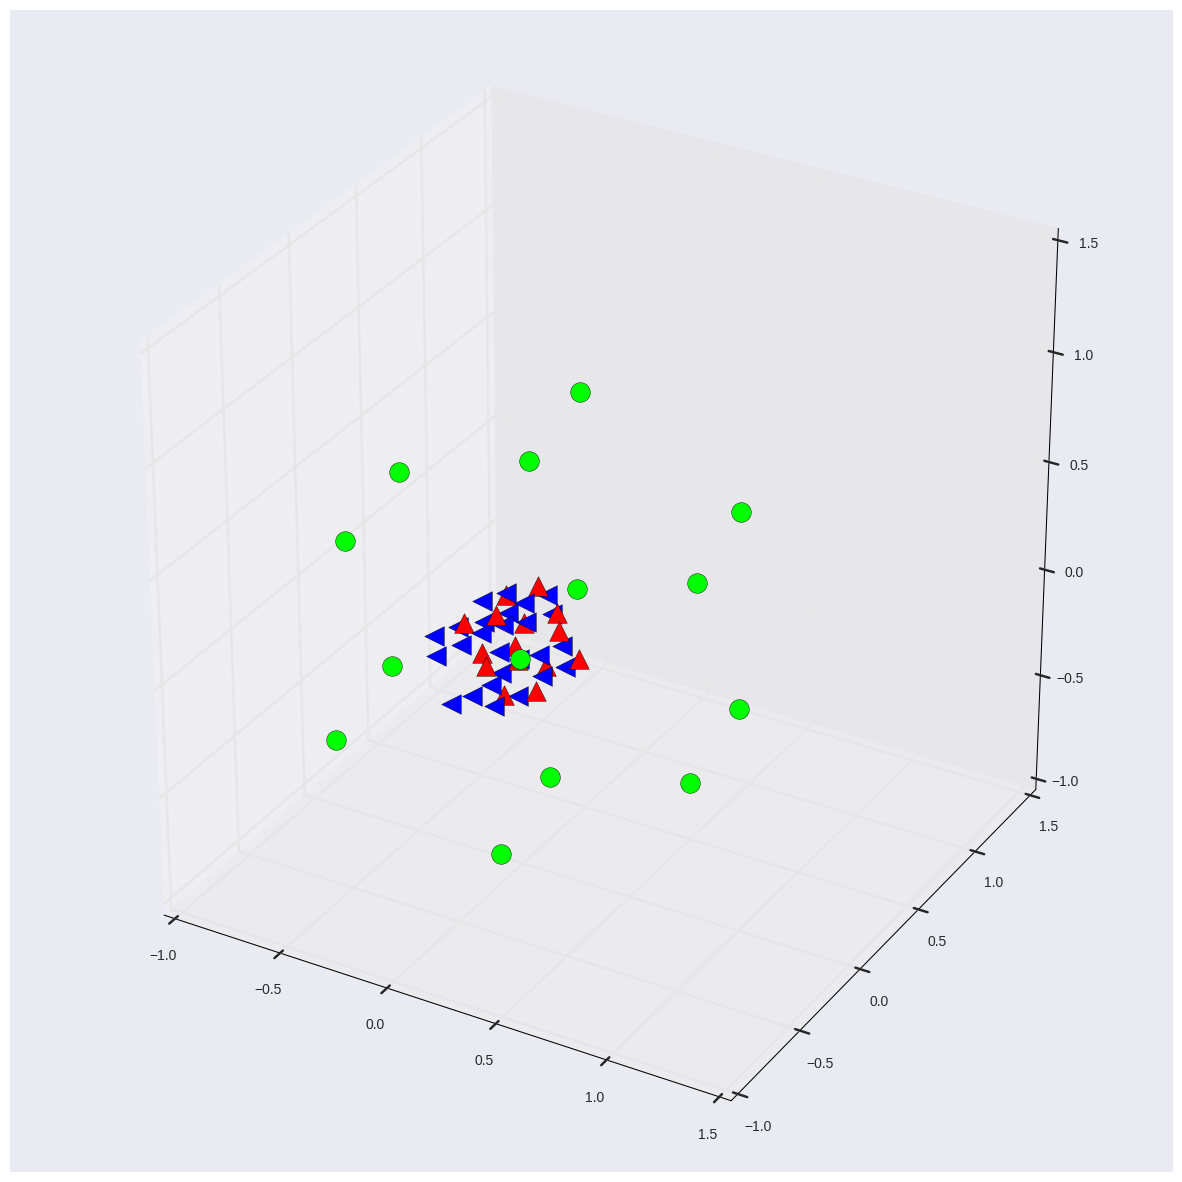

cgn centers:15 (green dots)
lust centers:14 (red triangles)
combined centers:26 (blue triangles)


In [30]:
show_3d_plot_centers(reduced_scaled_cgn_dataset_clusters[1],'o',kpca_reduced_scaled_cgn_dataset_clusters[1],'^',kpca_reduced_scaled_combined_dataset_clusters[1],'<')

print "cgn centers:{} (green dots)".format(len(kpca_reduced_scaled_cgn_dataset_clusters[1]))
print "lust centers:{} (red triangles)".format(len(kpca_reduced_scaled_lust_dataset_clusters[1]))
print "combined centers:{} (blue triangles)".format(len(kpca_reduced_scaled_combined_dataset_clusters[1]))

## 6.1 Analysis of Cluster similarity

### 6.2
To compare the different clustering results even better,
the following code blocks compute a mapping between the found clusters.
In other words, the question to be answered is this: In how many different clusters from the second result, are the points of one cluster in the first result?

This way the similarity of the two different clustering results can be seen.

To visualize this, for each datapoint in a cluster it is analyzed, in 
how many different clusters of the other result it appears.

For a perfect similarity every point of Cluster A should be in some Cluster B
of the other clustering result. 

#### Comparison of Pca and Kpca, with 3 dimensions 
The analysis shows that both algorithms kpca and pca, basically find the same clusters for the MaxABS Scaler.
Therefore it does not matter which algorithm to choose. 


In [31]:
def compare_clusters(dataset, clusters, clusters2):
    res={}
    for i, p in enumerate(dataset.iterrows()):
        cluster= clusters[i]    

        if (not cluster in res):
            res[cluster]={}
        other_cluster=clusters2[i]
        if (not other_cluster in res[cluster]):
            res[cluster][other_cluster]=0
        res[cluster][other_cluster]+=1
    return res

res=compare_clusters(reduced_scaled_cgn_dataset, kpca_reduced_scaled_cgn_dataset_clusters[0],reduced_scaled_cgn_dataset_clusters[0])
print "cgn_kpca #clusters:{}".format(len(kpca_reduced_scaled_cgn_dataset_clusters[1]))
print "cgn_pca #clusters:{}".format(len(reduced_scaled_cgn_dataset_clusters[1]))
print

print  "kpca_cluster --> [pca_cluster1: #points, pca_cluster2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)

cgn_kpca #clusters:15
cgn_pca #clusters:14

kpca_cluster --> [pca_cluster1: #points, pca_cluster2: #points....]
0 --> {5: 129}
1 --> {0: 64}
2 --> {7: 91}
3 --> {6: 122}
4 --> {1: 184}
5 --> {4: 178}
6 --> {3: 138}
7 --> {2: 99}
8 --> {9: 70}
9 --> {8: 70}
10 --> {10: 34}
11 --> {11: 15}
12 --> {12: 10}
13 --> {13: 8}
14 --> {9: 6}


In [32]:
#data, centers, preds
print "comparing combined dataset clusters of kpca and pca"

res=compare_clusters(reduced_scaled_combined_dataset, kpca_reduced_scaled_combined_dataset_clusters[0],reduced_scaled_combined_dataset_clusters[0])
print "combined_kpca #clusters:{}".format(len(kpca_reduced_scaled_combined_dataset_clusters[1]))
print "combined_pca #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters[1]))
print "kpca_cluster --> [pca_cluster1: #points, pca_cluster2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)

comparing combined dataset clusters of kpca and pca
combined_kpca #clusters:26
combined_pca #clusters:28
kpca_cluster --> [pca_cluster1: #points, pca_cluster2: #points....]
0 --> {4: 184}
1 --> {12: 35, 22: 35}
2 --> {6: 66}
3 --> {0: 138}
4 --> {1: 178}
5 --> {2: 122}
6 --> {8: 129}
7 --> {9: 46}
8 --> {5: 30}
9 --> {11: 91}
10 --> {7: 99}
11 --> {10: 34}
12 --> {3: 70}
13 --> {13: 23}
14 --> {16: 34}
15 --> {15: 15}
16 --> {27: 10, 14: 12}
17 --> {19: 9}
18 --> {21: 11}
19 --> {18: 10}
20 --> {26: 7}
21 --> {25: 3, 20: 8}
22 --> {17: 8}
23 --> {9: 3}
24 --> {23: 4}
25 --> {24: 6}


#### Comparison of PCA based clustering results with 3 dimensions and PCA based clustering with 4 dimensions
For an additional examination of clusters based of a PCA reduced dataset with 4 dimensions the following test was run.
The conclusion is that no additional value is achieved using 4 dimensions since the identified clusters are basically all the same. The only exception being that PCA-4 splits a few clusters even further.

In [33]:
#data, centers, preds
print "comparing combined dataset clusters of kpca and pca"

res=compare_clusters(reduced_scaled_combined_dataset4, reduced_scaled_combined_dataset_clusters[0],reduced_scaled_combined_dataset_clusters4[0])
print "combined_pca 4 dimensions #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters4[1]))
print "combined_pca #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters[1]))

print "pca_cluster3 --> [pca_cluster4_1: #points, pca_cluster4_2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)

comparing combined dataset clusters of kpca and pca
combined_pca 4 dimensions #clusters:25
combined_pca #clusters:28
pca_cluster3 --> [pca_cluster4_1: #points, pca_cluster4_2: #points....]
0 --> {9: 138}
1 --> {5: 178}
2 --> {4: 122}
3 --> {10: 70}
4 --> {6: 184}
5 --> {15: 30}
6 --> {1: 64, 13: 2}
7 --> {8: 99}
8 --> {0: 129}
9 --> {18: 3, 3: 46}
10 --> {7: 34}
11 --> {2: 91}
12 --> {12: 35}
13 --> {13: 23}
14 --> {16: 12}
15 --> {17: 15}
16 --> {14: 34}
17 --> {19: 8}
18 --> {20: 10}
19 --> {22: 9}
20 --> {23: 8}
21 --> {18: 11}
22 --> {12: 35}
23 --> {24: 4}
24 --> {21: 6}
25 --> {18: 3}
26 --> {11: 7}
27 --> {16: 10}


#### Comparison of PCA based clustering results with 3 dimensions with different feature scaling
The clustering results are very different. Not only is the number of clusters different, but the 2 clusters of the robust scaler 
do not form partitions of the max_abs clusters. The points are mixed across clusters. 

In [34]:
res=compare_clusters(reduced_scaled_combined_dataset, reduced_scaled_combined_dataset_clusters_robust[0],reduced_scaled_combined_dataset_clusters[0])
print "combined_pca robust scaler #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters_robust[1]))
print "combined_pca max_abs scaler #clusters:{}".format(len(reduced_scaled_combined_dataset_clusters[1]))

print "robust_cluster --> [cluster_maxabs_1: #points, cluster_maxabs_2: #points....]"
for key, value in res.iteritems():
        print "{} --> {}".format(key, value)
    

combined_pca robust scaler #clusters:2
combined_pca max_abs scaler #clusters:28
robust_cluster --> [cluster_maxabs_1: #points, cluster_maxabs_2: #points....]
0 --> {0: 138, 1: 176, 2: 121, 3: 70, 4: 183, 6: 64, 7: 98, 8: 129, 11: 85, 12: 35, 15: 15, 16: 32, 18: 10, 20: 8, 22: 35, 24: 6}
1 --> {1: 2, 2: 1, 4: 1, 5: 30, 6: 2, 7: 1, 9: 49, 10: 34, 11: 6, 13: 23, 14: 12, 16: 2, 17: 8, 19: 9, 21: 11, 23: 4, 25: 3, 26: 7, 27: 10}


## 6.3 Number of Trafficlights Distribution over clusters
Because the number of trafficlights is a very important value for the reinforcement learner (as I later found out),
it is essential to analyze how the different values are distributed among the clusters. For answering that question, a set of heatmaps was created. 
#### Cologne clusters with both scalers

Cologne- Analysis of Correlation between traffic light count and clustering result


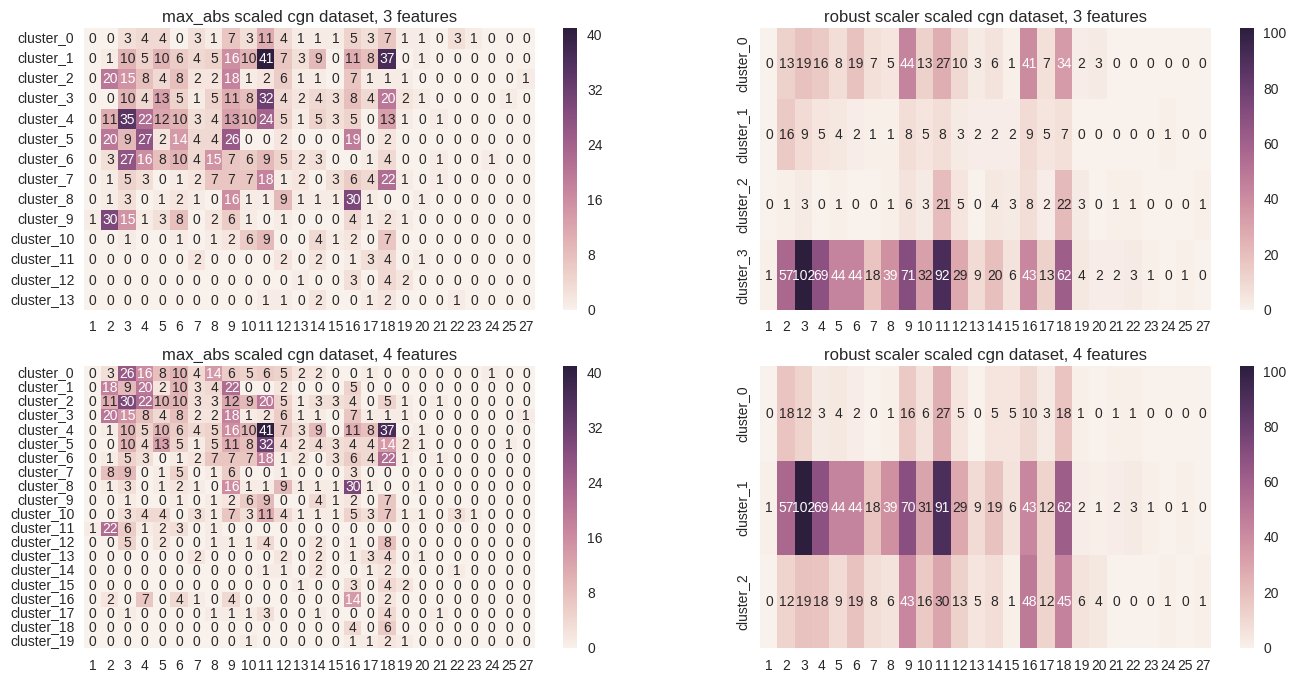

In [35]:
import matplotlib.pyplot as plt

def createSnsHeatmapData(dataset, clusters, count, uniquetrafficlights):                
        result= pd.DataFrame(columns= uniquetrafficlights)         
        for cluster in range(count):        
            d_temp=dataset.copy()
            d_temp['clusters']=clusters
            filteredbycluster= d_temp.loc[d_temp['clusters'] == cluster]        
            count= dataset["trafficlight_count"]            
            summed =filteredbycluster.groupby("trafficlight_count")["trafficlight_count"].count()
            summed.name= "cluster_{}".format(cluster)            
            result= result.append(summed)
        return result.fillna(0)
    
print "Cologne- Analysis of Correlation between traffic light count and clustering result"
f, axes = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
ax1,ax2=  axes[0]
ax3,ax4=  axes[1]
heatmapdata=createSnsHeatmapData(
    cgn_dataset, reduced_scaled_cgn_dataset_clusters[0],
    len(reduced_scaled_cgn_dataset_clusters[1]),
    unique_trafficlightcount_cgn
    )

ax1.set_title("max_abs scaled cgn dataset, 3 features")

sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax1)

heatmapdata=createSnsHeatmapData(
    cgn_dataset, reduced_scaled_cgn_dataset_clusters_robust[0],
    len(reduced_scaled_cgn_dataset_clusters_robust[1]),
    unique_trafficlightcount_cgn
    )
ax2.set_title("robust scaler scaled cgn dataset, 3 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax2)



heatmapdata=createSnsHeatmapData(
    cgn_dataset, reduced_scaled_cgn_dataset_clusters4[0],
    len(reduced_scaled_cgn_dataset_clusters4[1]),
    unique_trafficlightcount_cgn
    )
ax3.set_title("max_abs scaled cgn dataset, 4 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax3)

heatmapdata=createSnsHeatmapData(
    cgn_dataset, reduced_scaled_cgn_dataset_clusters_robust4[0],
    len(reduced_scaled_cgn_dataset_clusters_robust4[1]),
    unique_trafficlightcount_cgn
    )
ax4.set_title("robust scaler scaled cgn dataset, 4 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax4)

plt.show()


#### Lust clusters with both scalers

Lust- Analysis of Correlation between traffic light count and clustering result


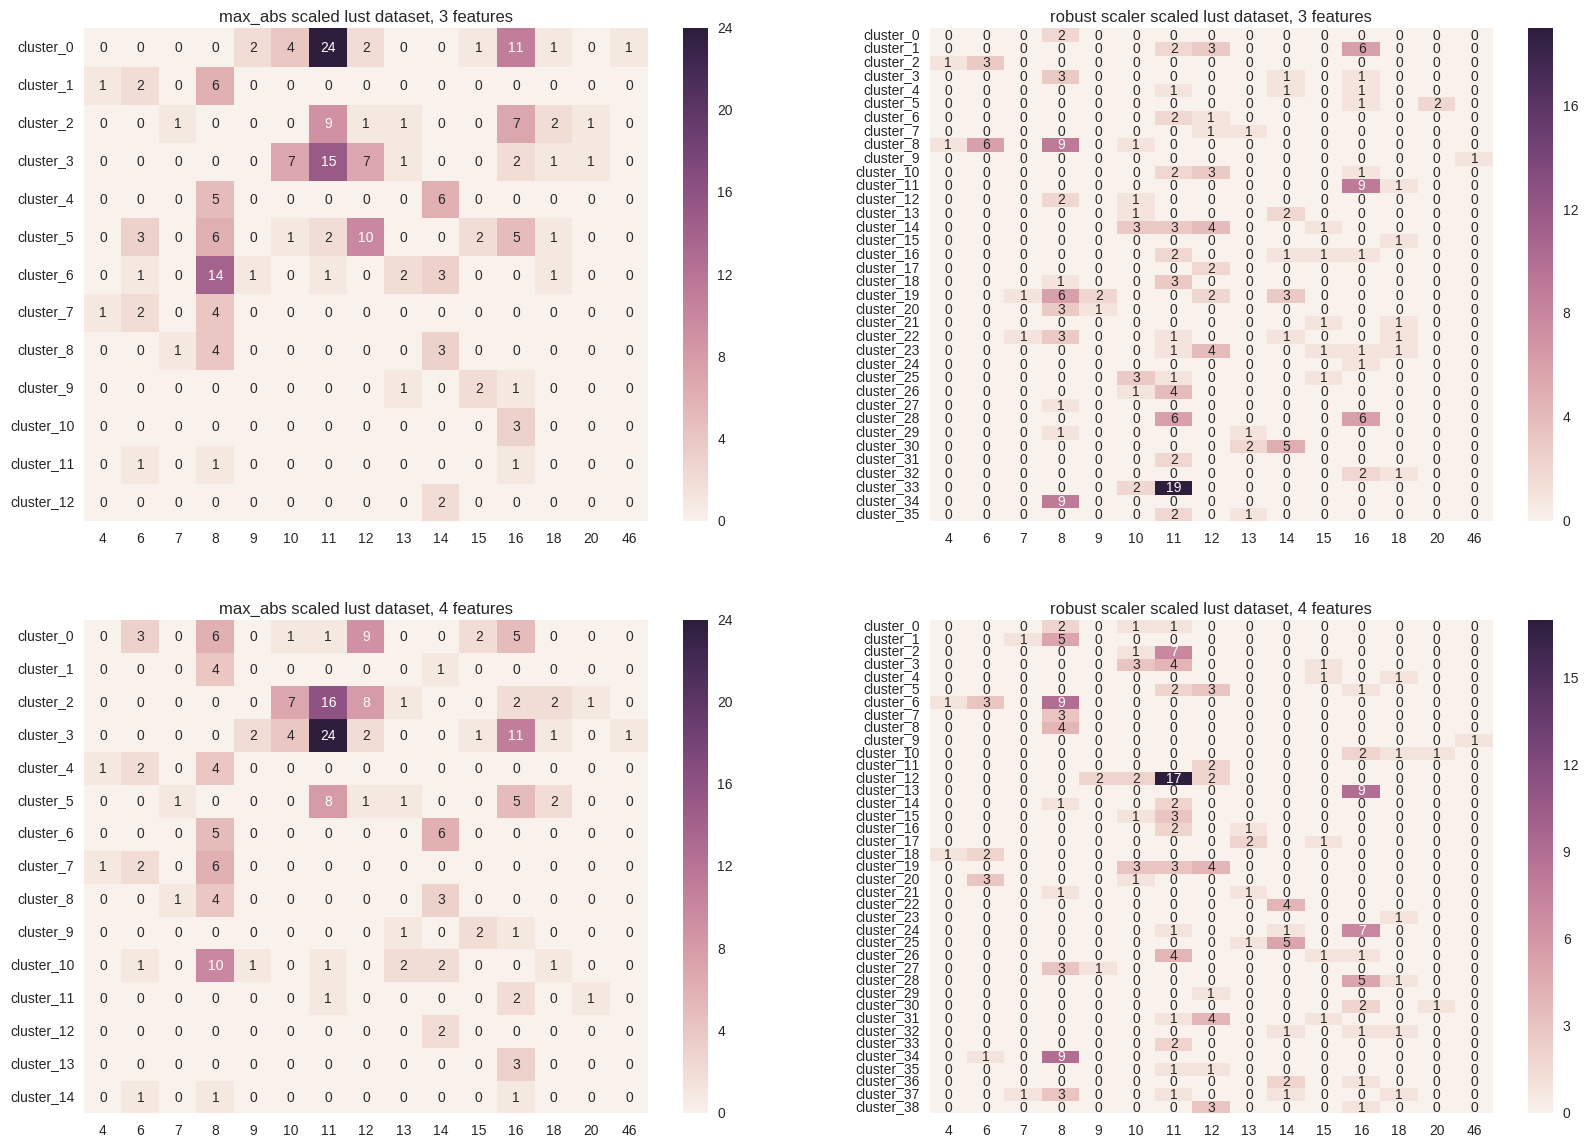

In [36]:
print "Lust- Analysis of Correlation between traffic light count and clustering result"
f, axes = plt.subplots(figsize=(20,14), nrows=2, ncols=2)
ax1,ax2=  axes[0]
ax3,ax4=  axes[1]
heatmapdata=createSnsHeatmapData(
    lust_dataset, reduced_scaled_lust_dataset_clusters[0],
    len(reduced_scaled_lust_dataset_clusters[1]),
    unique_trafficlightcount_lust
    )
ax1.set_title("max_abs scaled lust dataset, 3 features")

sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax1)

heatmapdata=createSnsHeatmapData(
    lust_dataset, reduced_scaled_lust_dataset_clusters_robust[0],
    len(reduced_scaled_lust_dataset_clusters_robust[1]),
    unique_trafficlightcount_lust
    )
ax2.set_title("robust scaler scaled lust dataset, 3 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax2)



heatmapdata=createSnsHeatmapData(
    lust_dataset, reduced_scaled_lust_dataset_clusters4[0],
    len(reduced_scaled_lust_dataset_clusters4[1]),
    unique_trafficlightcount_lust
    )
ax3.set_title("max_abs scaled lust dataset, 4 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax3)

heatmapdata=createSnsHeatmapData(
    lust_dataset, reduced_scaled_lust_dataset_clusters_robust4[0],
    len(reduced_scaled_lust_dataset_clusters_robust4[1]),
    unique_trafficlightcount_lust
    )
ax4.set_title("robust scaler scaled lust dataset, 4 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax4)

plt.show()

#### Combined clusters with both scalers

Combined- Analysis of Correlation between traffic light count and clustering result


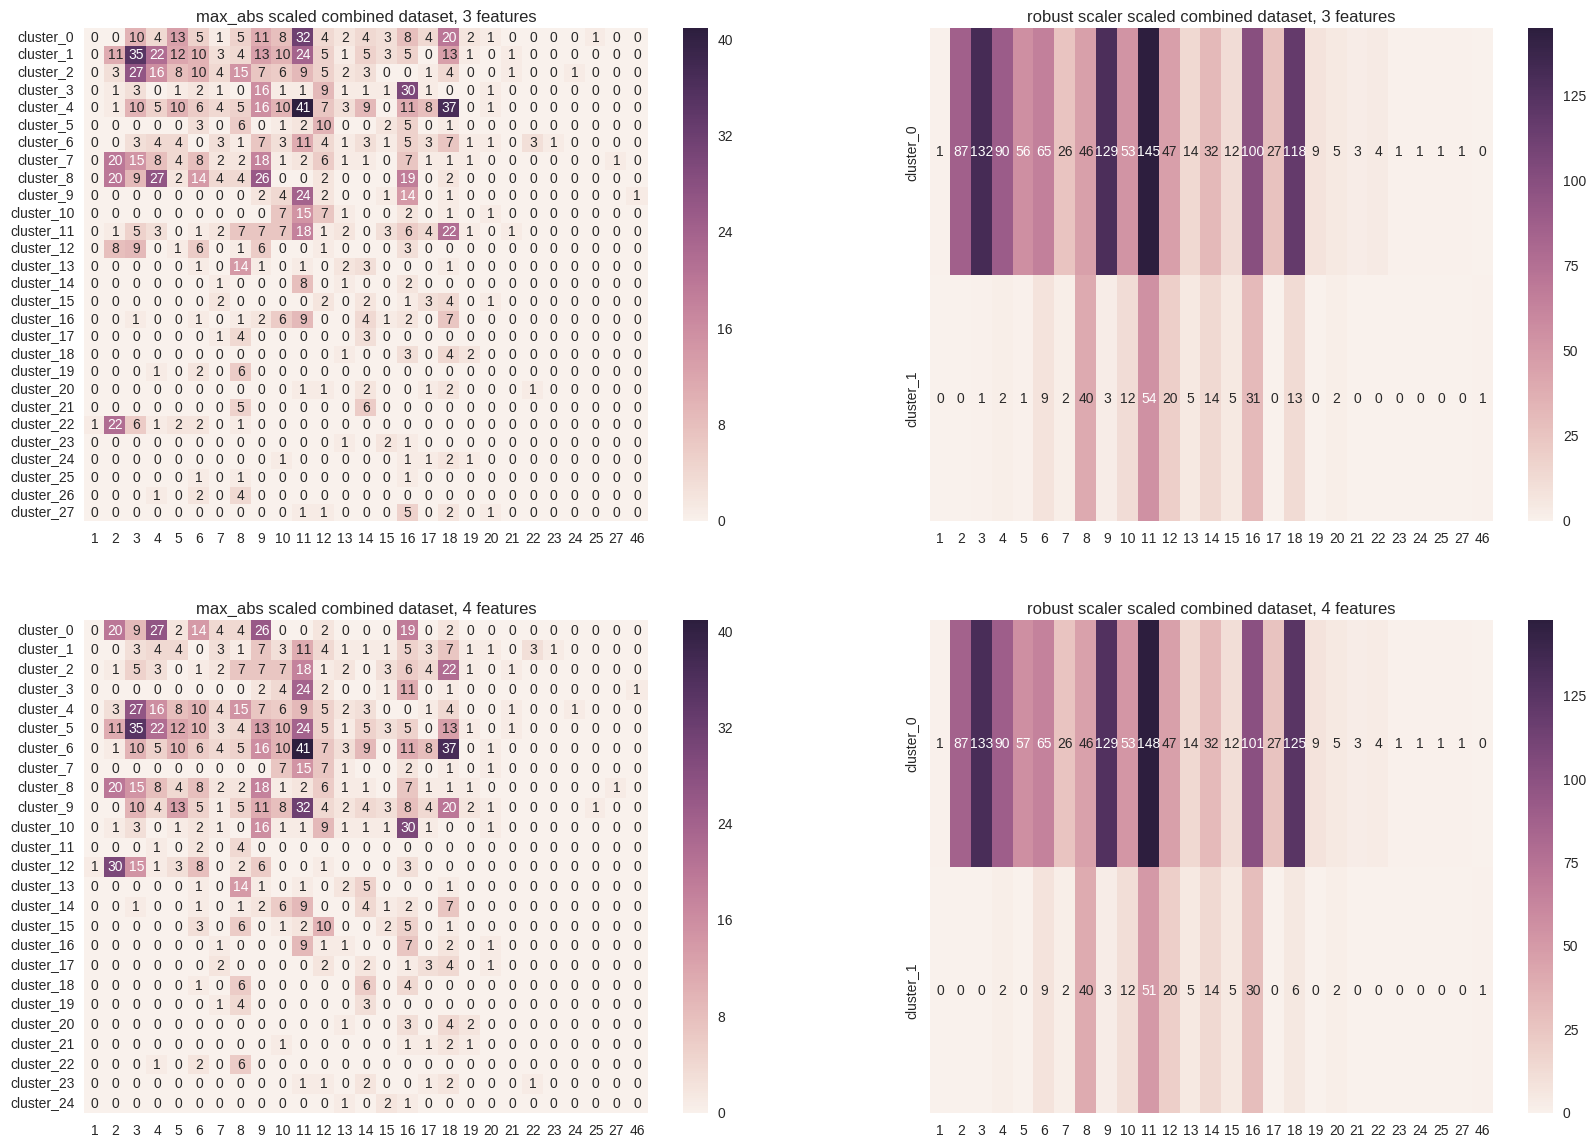

In [37]:
print "Combined- Analysis of Correlation between traffic light count and clustering result"
f, axes = plt.subplots(figsize=(20,14), nrows=2, ncols=2)
ax1,ax2=  axes[0]
ax3,ax4=  axes[1]
heatmapdata=createSnsHeatmapData(
    combined_dataset, reduced_scaled_combined_dataset_clusters[0],
    len(reduced_scaled_combined_dataset_clusters[1]),
    unique_trafficlightcount_combined
    )
ax1.set_title("max_abs scaled combined dataset, 3 features")

sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax1)

heatmapdata=createSnsHeatmapData(
    combined_dataset, reduced_scaled_combined_dataset_clusters_robust[0],
    len(reduced_scaled_combined_dataset_clusters_robust[1]),
    unique_trafficlightcount_combined
    )
ax2.set_title("robust scaler scaled combined dataset, 3 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax2)



heatmapdata=createSnsHeatmapData(
    combined_dataset, reduced_scaled_combined_dataset_clusters4[0],
    len(reduced_scaled_combined_dataset_clusters4[1]),
    unique_trafficlightcount_combined
    )
ax3.set_title("max_abs scaled combined dataset, 4 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax3)

heatmapdata=createSnsHeatmapData(
    combined_dataset, reduced_scaled_combined_dataset_clusters_robust4[0],
    len(reduced_scaled_combined_dataset_clusters_robust4[1]),
    unique_trafficlightcount_combined
    )
ax4.set_title("robust scaler scaled combined dataset, 4 features")
sns.heatmap(heatmapdata, annot=True, fmt="g", ax=ax4)

plt.show()


## 6.3 Conclusion of Analysis



# 7 Data Export
Finally append the clustering information to the dataset and write it back to a CSV file. 
Although the datasets own clusters using an maxabs scaler were providing the best results, 
I included the robust_scaler and combined datasets clustering results. Maybe there will be time left
to try the reinforcement learner with those results too. 

In [38]:

lust_raw_df= pd.read_csv(lust_file_name)
cgn_raw_df= pd.read_csv(cgn_file_name)
cgn_raw_df.columns= copy.copy(columns)
lust_raw_df.columns= copy.copy(columns)

clusters_maxabs_cgn= reduced_scaled_cgn_dataset_clusters[0]
clusters_robust_cgn= reduced_scaled_cgn_dataset_clusters_robust[0]

clusters_maxabs_lust= reduced_scaled_lust_dataset_clusters[0]
clusters_robust_lust= reduced_scaled_lust_dataset_clusters_robust[0]

lust_item_count= len(lust_raw_df)

#split the combined clusters into cgn and lust part
clusters_combined_cgn=reduced_scaled_combined_dataset_clusters[0][lust_item_count:]
clusters_combined_robust_cgn=reduced_scaled_combined_dataset_clusters_robust[0][lust_item_count:]

clusters_combined_lust=reduced_scaled_combined_dataset_clusters[0][:lust_item_count]
clusters_combined_robust_lust=reduced_scaled_combined_dataset_clusters_robust[0][:lust_item_count]


cgn_raw_df['clusters_maxabs_3dimensions']=clusters_maxabs_cgn
cgn_raw_df['clusters_robust_3dimensions']=clusters_robust_cgn 

cgn_raw_df['clusters_combined_3dimensions']=clusters_combined_cgn
cgn_raw_df['clusters_combined_robust_3dimensions']=clusters_combined_robust_cgn

lust_raw_df['clusters_maxabs_3dimensions']=clusters_maxabs_lust
lust_raw_df['clusters_robust_3dimensions']=clusters_robust_lust 

lust_raw_df['clusters_combined_3dimensions']=clusters_combined_lust
lust_raw_df['clusters_combined_robust_3dimensions']=clusters_combined_robust_lust


cgn_raw_df.to_csv("dataset-cgn-tl-clusters.csv")
lust_raw_df.to_csv("dataset-lust-tl-clusters.csv")
